Import libraries and init wandb for loss and accuracy tracing

In [1]:
import wandb

wandb.init(project="test3", entity="xhradskyp")

wandb: Currently logged in as: xhradskyp. Use `wandb login --relogin` to force relogin


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime
from torch.utils.data import random_split
from torchmetrics.functional import dice
from sklearn.metrics import roc_curve
from sklearn.utils.multiclass import type_of_target

Create an Unet class and init the model with 1 in channel and 3 out channels

In [2]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

net = UNET(3, 1)

Prepare the data into Dataset object. 

All the classes in labels are set to 1, extract blocks function makes 64x64px overlapping patches from those images

In [3]:
def extract_blocks(images):
    count,M,N,ch = images.shape
    w, h = 64, 64
    new = np.empty((count*49, w, h, ch), dtype=np.uint8)
    i = 0
    for image in images:
        for j in range(7):
            for k in range(7):
                new[i] = image[k*32:(k+1)*64-k*32, j*32:(j+1)*64-j*32]
                i += 1
    return new

class MyDataset(Dataset):
    def __init__(self):
        images = np.load("data/images.npy")
        labels = np.load("data/labels.npy")
        
        images = extract_blocks(images)
        print("done")
        labels = extract_blocks(labels)
        print("done")
        labels = labels[..., 1]
        labels[labels >= 1] = 1
        print("done")
        
        images = torch.tensor(images)
        labels = torch.tensor(labels)
        print(images.shape)
        self.images = images.permute((0, 3, 1, 2))
        self.labels = labels

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]

In [4]:
dataset = MyDataset()

done
done
done
torch.Size([244069, 64, 64, 3])


Visualize the sample of image and mask from dataset

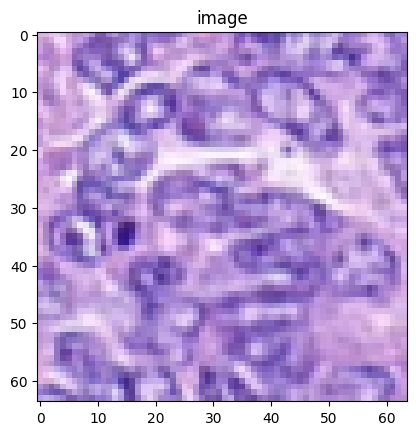

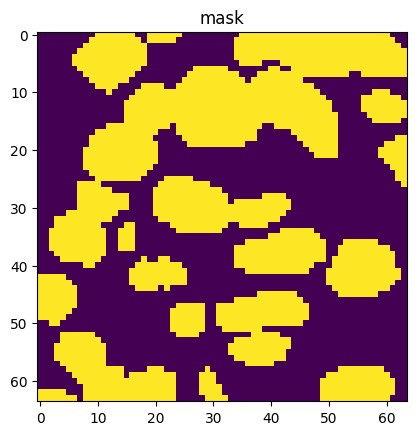

In [5]:
x = 123
plt.imshow(dataset[x][0].float().permute((1, 2, 0)).detach().numpy()/255)
plt.title("image")
plt.show()
plt.imshow(dataset[x][1].float().detach().numpy())
plt.title("mask")
plt.show()

Split the dataset to train (200000) and test (44069) and create dataloader with batch size of 32 (or 64) and shuffled data

In [8]:
train_data, test_data = random_split(dataset, [200000, 44069])
dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)

Prepare constants, functions and model for training.

 - epochs: 2
 - model: UNET
 - loss function: BCEWithLogitsLoss
 - optimizer: Adam with learning rate 0.01 (or 0.001)

In [12]:
num_epochs = 2
total_samples = len(train_data)
n_iterations = math.ceil(total_samples/32)
print(total_samples, n_iterations)
net = UNET(3, 1)
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(net.parameters(), lr=0.01)
def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean()

200000 6250


Training the model, logging the loss and accuracy.

Visualize training sample every 200 steps.

epoch 1/2, step 20/6250, loss 0.5719052970409393, acc 0.8104324340820312, time 0:00:22.634796
epoch 1/2, step 40/6250, loss 0.4554779529571533, acc 0.8533477783203125, time 0:00:44.767018
epoch 1/2, step 60/6250, loss 0.3680809438228607, acc 0.8427505493164062, time 0:01:06.625197
epoch 1/2, step 80/6250, loss 0.33547709733247755, acc 0.8172149658203125, time 0:01:28.773238
epoch 1/2, step 100/6250, loss 0.31629601269960406, acc 0.8164138793945312, time 0:01:50.877671
epoch 1/2, step 120/6250, loss 0.31243997514247895, acc 0.86273193359375, time 0:02:12.375964
epoch 1/2, step 140/6250, loss 0.292610864341259, acc 0.85101318359375, time 0:02:35.944362
epoch 1/2, step 160/6250, loss 0.28549477756023406, acc 0.8552169799804688, time 0:02:57.297712
epoch 1/2, step 180/6250, loss 0.28385848701000216, acc 0.8747406005859375, time 0:03:18.467698
epoch 1/2, step 200/6250, loss 0.27474265396595, acc 0.8387374877929688, time 0:03:40.096080


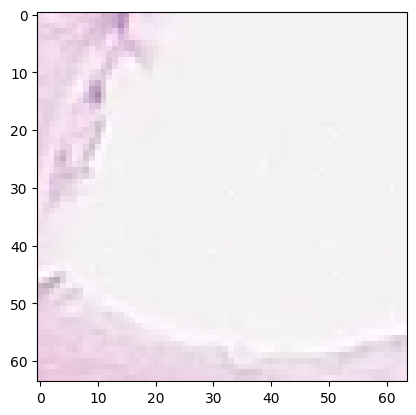

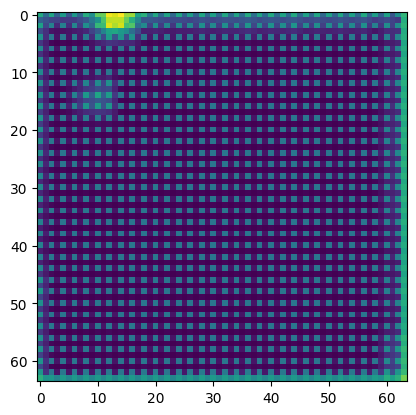

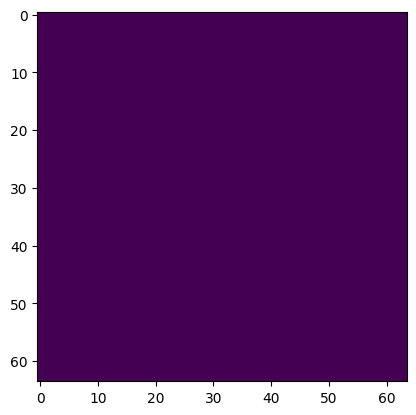

epoch 1/2, step 220/6250, loss 0.26275770738720894, acc 0.8365020751953125, time 0:04:02.676254
epoch 1/2, step 240/6250, loss 0.2700508914887905, acc 0.8235702514648438, time 0:04:22.975442
epoch 1/2, step 260/6250, loss 0.26379491984844206, acc 0.8780670166015625, time 0:04:44.037037
epoch 1/2, step 280/6250, loss 0.2544358417391777, acc 0.82806396484375, time 0:05:04.720246
epoch 1/2, step 300/6250, loss 0.25467697307467463, acc 0.8337860107421875, time 0:05:24.913539
epoch 1/2, step 320/6250, loss 0.2535791374742985, acc 0.860595703125, time 0:05:44.363119
epoch 1/2, step 340/6250, loss 0.24076791405677794, acc 0.8428497314453125, time 0:06:04.257252
epoch 1/2, step 360/6250, loss 0.24818259105086327, acc 0.84967041015625, time 0:06:23.641883
epoch 1/2, step 380/6250, loss 0.24038899764418603, acc 0.8235702514648438, time 0:06:43.971919
epoch 1/2, step 400/6250, loss 0.22592976465821266, acc 0.8543624877929688, time 0:07:04.047065


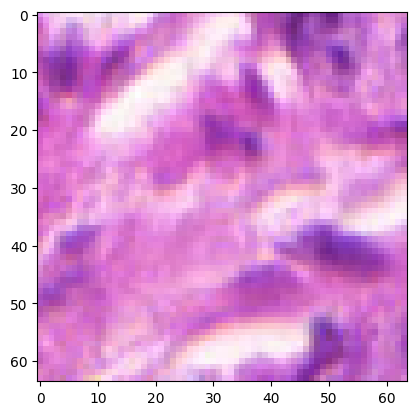

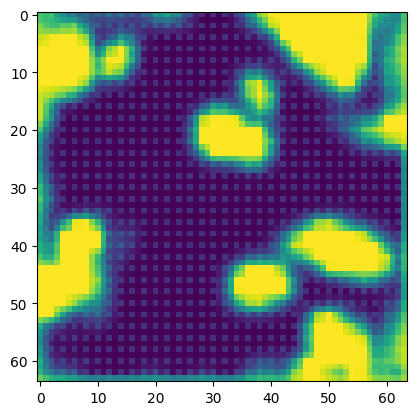

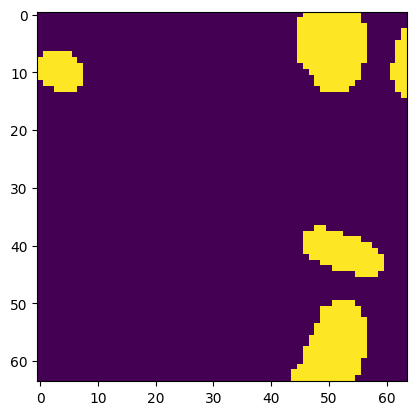

epoch 1/2, step 420/6250, loss 0.24298107028007507, acc 0.843292236328125, time 0:07:25.568973
epoch 1/2, step 440/6250, loss 0.22676264941692353, acc 0.8494033813476562, time 0:07:45.154091
epoch 1/2, step 460/6250, loss 0.22262700647115707, acc 0.8404464721679688, time 0:08:05.071942
epoch 1/2, step 480/6250, loss 0.22243614494800568, acc 0.8455429077148438, time 0:08:25.151112
epoch 1/2, step 500/6250, loss 0.22983405590057374, acc 0.8543167114257812, time 0:08:44.823611
epoch 1/2, step 520/6250, loss 0.23387564942240716, acc 0.8389434814453125, time 0:09:04.038253
epoch 1/2, step 540/6250, loss 0.21430548131465912, acc 0.8649978637695312, time 0:09:23.978234
epoch 1/2, step 560/6250, loss 0.2269088752567768, acc 0.8280029296875, time 0:09:43.723609
epoch 1/2, step 580/6250, loss 0.20938757285475731, acc 0.8202285766601562, time 0:10:03.105149
epoch 1/2, step 600/6250, loss 0.20664884373545647, acc 0.8655319213867188, time 0:10:22.494739


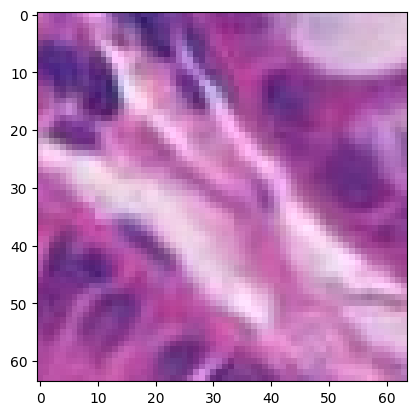

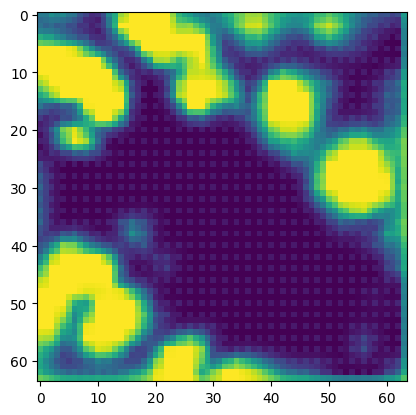

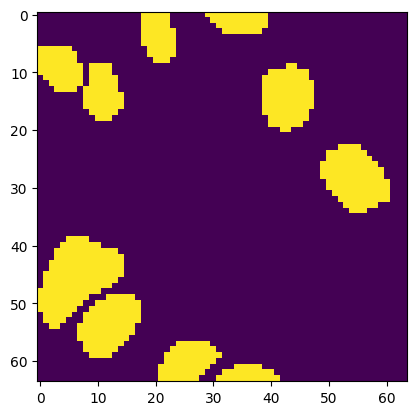

epoch 1/2, step 620/6250, loss 0.2291410282254219, acc 0.82012939453125, time 0:10:42.864416
epoch 1/2, step 640/6250, loss 0.21197514459490777, acc 0.843963623046875, time 0:11:02.613450
epoch 1/2, step 660/6250, loss 0.20606062933802605, acc 0.839141845703125, time 0:11:23.393204
epoch 1/2, step 680/6250, loss 0.20171201154589652, acc 0.8722610473632812, time 0:11:43.075908
epoch 1/2, step 700/6250, loss 0.22031843140721322, acc 0.8221054077148438, time 0:12:02.170105
epoch 1/2, step 720/6250, loss 0.20192776173353194, acc 0.85540771484375, time 0:12:21.618898
epoch 1/2, step 740/6250, loss 0.2040753595530987, acc 0.8209152221679688, time 0:12:40.954381
epoch 1/2, step 760/6250, loss 0.19958515614271163, acc 0.8541259765625, time 0:13:00.085871
epoch 1/2, step 780/6250, loss 0.20134712234139443, acc 0.8430099487304688, time 0:13:18.388797
epoch 1/2, step 800/6250, loss 0.20823521688580512, acc 0.8416748046875, time 0:13:35.901904


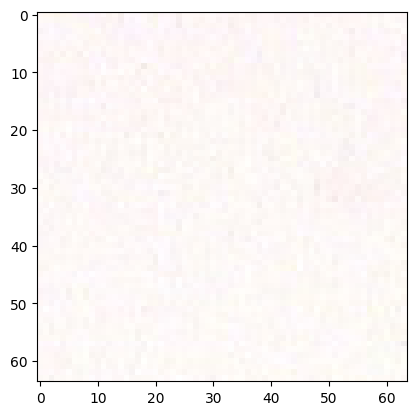

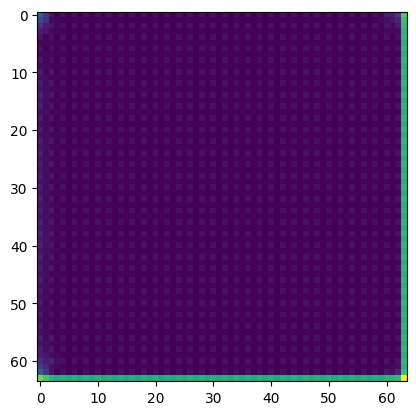

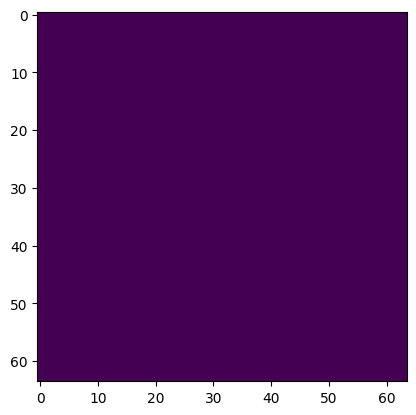

epoch 1/2, step 820/6250, loss 0.21016855761408806, acc 0.82806396484375, time 0:13:53.576717
epoch 1/2, step 840/6250, loss 0.2006815940141678, acc 0.8300094604492188, time 0:14:11.049932
epoch 1/2, step 860/6250, loss 0.20535862296819687, acc 0.8448715209960938, time 0:14:29.055940
epoch 1/2, step 880/6250, loss 0.20185971036553382, acc 0.8367233276367188, time 0:14:47.035437
epoch 1/2, step 900/6250, loss 0.19774970784783363, acc 0.8350448608398438, time 0:15:04.792229
epoch 1/2, step 920/6250, loss 0.2000804252922535, acc 0.82232666015625, time 0:15:22.846915
epoch 1/2, step 940/6250, loss 0.20470375269651414, acc 0.8460006713867188, time 0:15:40.471003
epoch 1/2, step 960/6250, loss 0.19496387913823127, acc 0.8655548095703125, time 0:15:58.125159
epoch 1/2, step 980/6250, loss 0.19883006811141968, acc 0.8587722778320312, time 0:16:15.991479
epoch 1/2, step 1000/6250, loss 0.19824329987168313, acc 0.81488037109375, time 0:16:33.861580


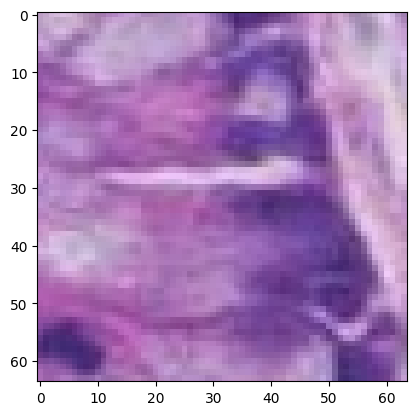

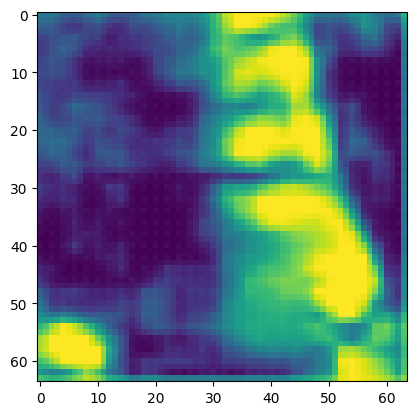

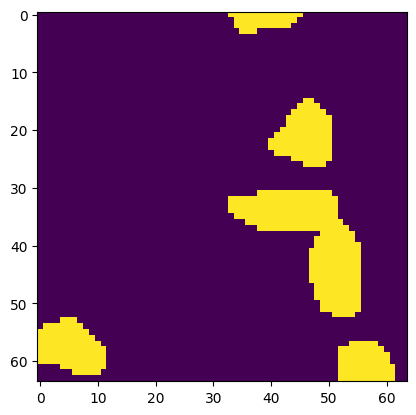

epoch 1/2, step 1020/6250, loss 0.18944677114486694, acc 0.8813018798828125, time 0:16:52.482849
epoch 1/2, step 1040/6250, loss 0.20230405181646346, acc 0.831024169921875, time 0:17:10.167846
epoch 1/2, step 1060/6250, loss 0.18813778460025787, acc 0.841064453125, time 0:17:29.649935
epoch 1/2, step 1080/6250, loss 0.18567749559879304, acc 0.8383026123046875, time 0:17:47.366601
epoch 1/2, step 1100/6250, loss 0.19019137769937516, acc 0.7902755737304688, time 0:18:05.071418
epoch 1/2, step 1120/6250, loss 0.1842356212437153, acc 0.859710693359375, time 0:18:24.229888
epoch 1/2, step 1140/6250, loss 0.1961241066455841, acc 0.8243484497070312, time 0:18:43.123853
epoch 1/2, step 1160/6250, loss 0.19410300701856614, acc 0.8048553466796875, time 0:19:01.311037
epoch 1/2, step 1180/6250, loss 0.1824832409620285, acc 0.822357177734375, time 0:19:18.630797
epoch 1/2, step 1200/6250, loss 0.19254890009760856, acc 0.8770523071289062, time 0:19:36.618784


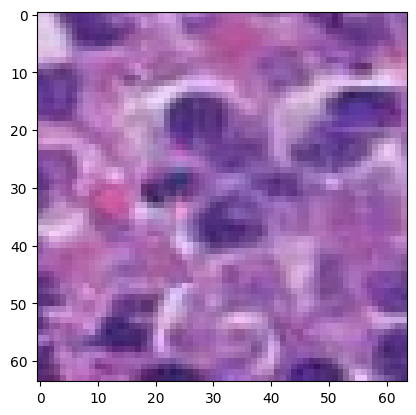

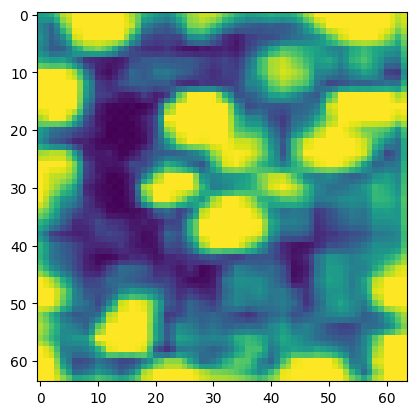

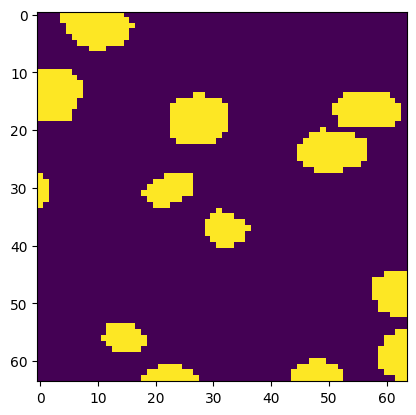

epoch 1/2, step 1220/6250, loss 0.18751984387636184, acc 0.8130416870117188, time 0:19:55.501772
epoch 1/2, step 1240/6250, loss 0.18305322006344796, acc 0.8687515258789062, time 0:20:12.472737
epoch 1/2, step 1260/6250, loss 0.17760764211416244, acc 0.8236160278320312, time 0:20:30.167021
epoch 1/2, step 1280/6250, loss 0.18245892897248267, acc 0.8421173095703125, time 0:20:48.074684
epoch 1/2, step 1300/6250, loss 0.1893956854939461, acc 0.8194427490234375, time 0:21:05.782050
epoch 1/2, step 1320/6250, loss 0.17557932063937187, acc 0.8570404052734375, time 0:21:23.814212
epoch 1/2, step 1340/6250, loss 0.18523596078157425, acc 0.843994140625, time 0:21:41.346237
epoch 1/2, step 1360/6250, loss 0.17680439203977585, acc 0.83941650390625, time 0:21:59.141738
epoch 1/2, step 1380/6250, loss 0.17509286403656005, acc 0.8537673950195312, time 0:22:16.475600
epoch 1/2, step 1400/6250, loss 0.17927506640553476, acc 0.8511886596679688, time 0:22:34.467295


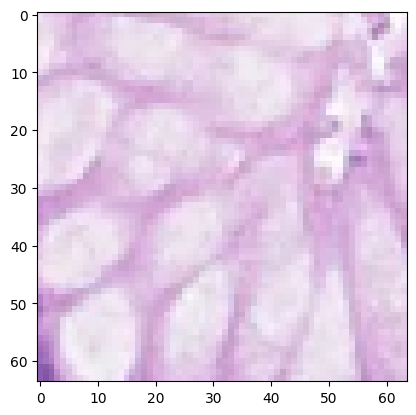

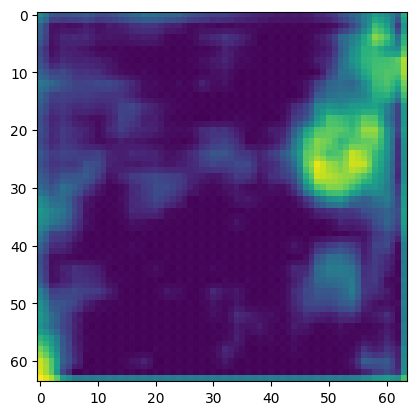

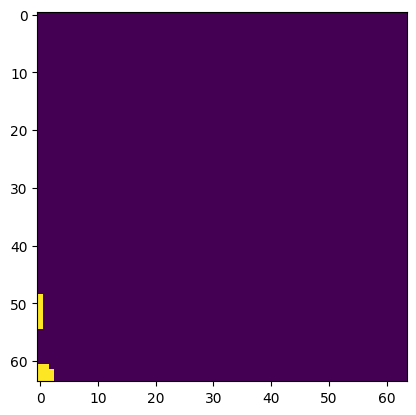

epoch 1/2, step 1420/6250, loss 0.1825107216835022, acc 0.8799591064453125, time 0:22:52.691788
epoch 1/2, step 1440/6250, loss 0.1753654107451439, acc 0.8145523071289062, time 0:23:10.646921
epoch 1/2, step 1460/6250, loss 0.17771596536040307, acc 0.8517990112304688, time 0:23:28.726315
epoch 1/2, step 1480/6250, loss 0.16793653443455697, acc 0.854827880859375, time 0:23:46.038329
epoch 1/2, step 1500/6250, loss 0.18145229518413544, acc 0.8554000854492188, time 0:24:03.747204
epoch 1/2, step 1520/6250, loss 0.17982295975089074, acc 0.8554153442382812, time 0:24:21.651289
epoch 1/2, step 1540/6250, loss 0.1700834386050701, acc 0.8345184326171875, time 0:24:39.219443
epoch 1/2, step 1560/6250, loss 0.17899090573191642, acc 0.8424530029296875, time 0:24:56.714213
epoch 1/2, step 1580/6250, loss 0.17077029421925544, acc 0.8762054443359375, time 0:25:14.379283
epoch 1/2, step 1600/6250, loss 0.18004260137677192, acc 0.8132858276367188, time 0:25:32.060360


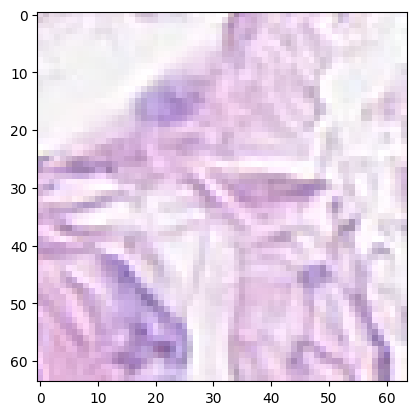

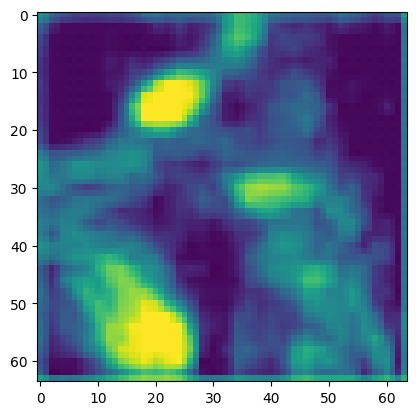

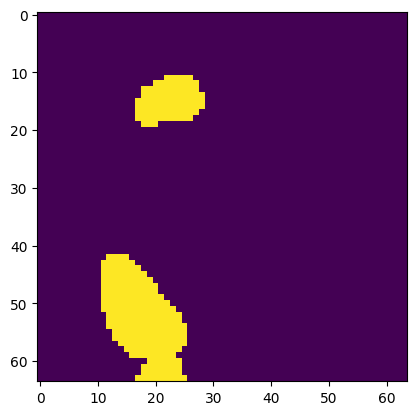

epoch 1/2, step 1620/6250, loss 0.17630007416009902, acc 0.8320388793945312, time 0:25:50.073304
epoch 1/2, step 1640/6250, loss 0.17571551874279975, acc 0.8177261352539062, time 0:26:07.460701
epoch 1/2, step 1660/6250, loss 0.17811085805296897, acc 0.8657150268554688, time 0:26:25.090375
epoch 1/2, step 1680/6250, loss 0.17572231143712996, acc 0.8289871215820312, time 0:26:42.712003
epoch 1/2, step 1700/6250, loss 0.17724615037441255, acc 0.8344802856445312, time 0:27:00.516032
epoch 1/2, step 1720/6250, loss 0.16870489791035653, acc 0.8362503051757812, time 0:27:17.972061
epoch 1/2, step 1740/6250, loss 0.17912424579262734, acc 0.8488235473632812, time 0:27:35.494207
epoch 1/2, step 1760/6250, loss 0.1770814560353756, acc 0.8074264526367188, time 0:27:53.146286
epoch 1/2, step 1780/6250, loss 0.17086131051182746, acc 0.8378143310546875, time 0:28:10.646153
epoch 1/2, step 1800/6250, loss 0.17886841744184495, acc 0.8444976806640625, time 0:28:28.121204


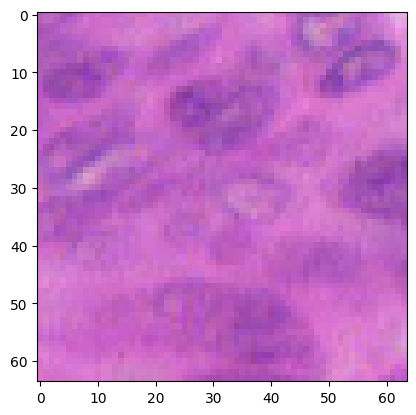

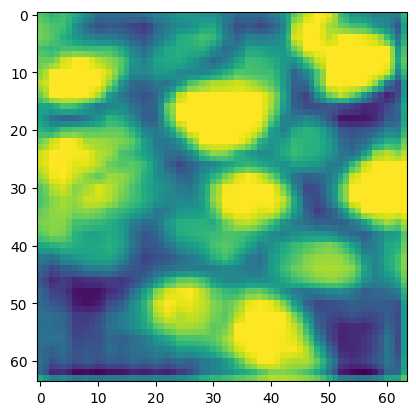

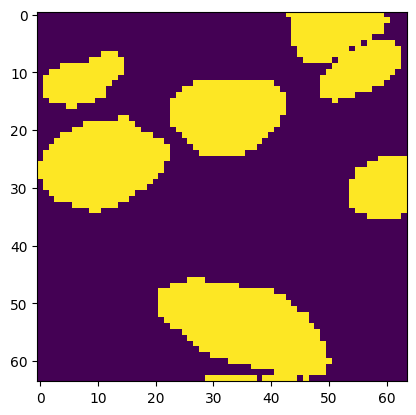

epoch 1/2, step 1820/6250, loss 0.16890587508678437, acc 0.8294601440429688, time 0:28:46.491479
epoch 1/2, step 1840/6250, loss 0.17648067250847815, acc 0.85675048828125, time 0:29:04.092165
epoch 1/2, step 1860/6250, loss 0.1783166565001011, acc 0.8429412841796875, time 0:29:21.783422
epoch 1/2, step 1880/6250, loss 0.17839970588684081, acc 0.8316421508789062, time 0:29:39.203622
epoch 1/2, step 1900/6250, loss 0.17990302741527558, acc 0.8445663452148438, time 0:29:57.078144
epoch 1/2, step 1920/6250, loss 0.17918184399604797, acc 0.8213958740234375, time 0:30:15.055871
epoch 1/2, step 1940/6250, loss 0.16541110426187516, acc 0.8632354736328125, time 0:30:35.044836
epoch 1/2, step 1960/6250, loss 0.17398588806390763, acc 0.8547515869140625, time 0:30:54.770597
epoch 1/2, step 1980/6250, loss 0.16422297358512877, acc 0.8774948120117188, time 0:31:13.905483
epoch 1/2, step 2000/6250, loss 0.168795295804739, acc 0.8452072143554688, time 0:31:31.776809


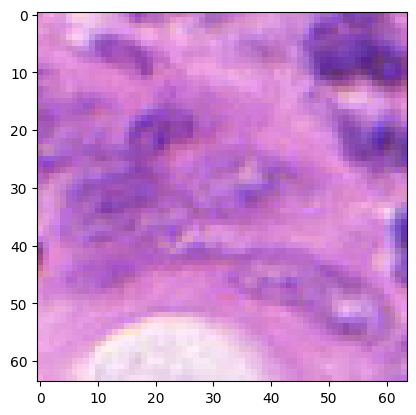

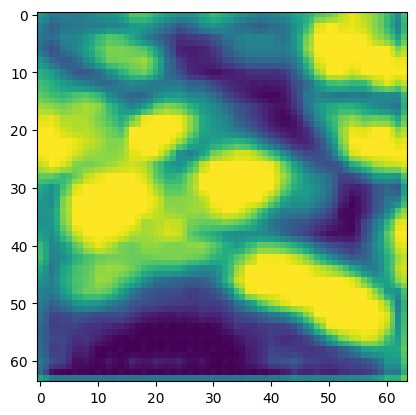

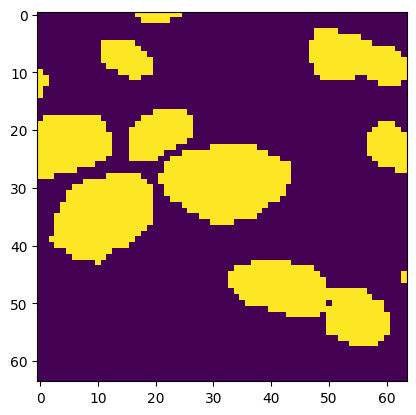

epoch 1/2, step 2020/6250, loss 0.1861454464495182, acc 0.7878646850585938, time 0:31:50.511674
epoch 1/2, step 2040/6250, loss 0.18027156144380568, acc 0.8055038452148438, time 0:32:08.274487
epoch 1/2, step 2060/6250, loss 0.18481432944536208, acc 0.8075027465820312, time 0:32:25.653005
epoch 1/2, step 2080/6250, loss 0.17603738158941268, acc 0.8172454833984375, time 0:32:44.087205
epoch 1/2, step 2100/6250, loss 0.17002682909369468, acc 0.8116378784179688, time 0:33:04.399655
epoch 1/2, step 2120/6250, loss 0.17377472668886185, acc 0.8209991455078125, time 0:33:21.998647
epoch 1/2, step 2140/6250, loss 0.17817411124706267, acc 0.8109664916992188, time 0:33:40.103871
epoch 1/2, step 2160/6250, loss 0.17102323323488236, acc 0.8223724365234375, time 0:33:57.883358
epoch 1/2, step 2180/6250, loss 0.17385610491037368, acc 0.840545654296875, time 0:34:15.198313
epoch 1/2, step 2200/6250, loss 0.16986248195171355, acc 0.8406524658203125, time 0:34:32.825964


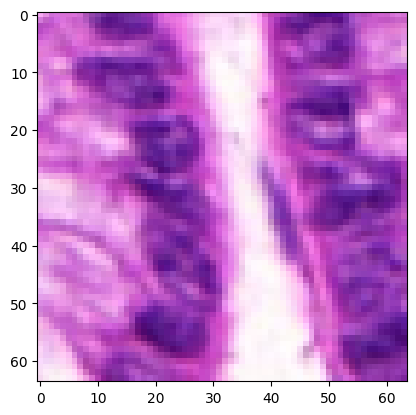

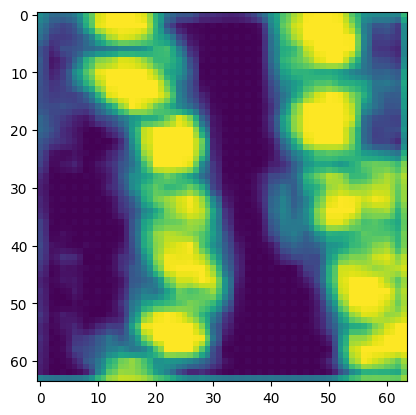

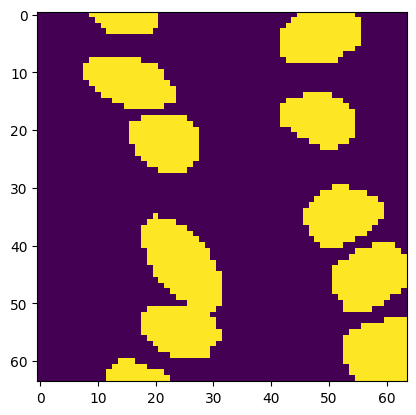

epoch 1/2, step 2220/6250, loss 0.16877980828285216, acc 0.826812744140625, time 0:34:50.752539
epoch 1/2, step 2240/6250, loss 0.16522375047206878, acc 0.83349609375, time 0:35:08.602813
epoch 1/2, step 2260/6250, loss 0.16293645948171614, acc 0.8671722412109375, time 0:35:26.299690
epoch 1/2, step 2280/6250, loss 0.1710096500813961, acc 0.8428497314453125, time 0:35:44.149099
epoch 1/2, step 2300/6250, loss 0.17246074303984643, acc 0.8157272338867188, time 0:36:01.184567
epoch 1/2, step 2320/6250, loss 0.17036761566996575, acc 0.8560714721679688, time 0:36:17.944655
epoch 1/2, step 2340/6250, loss 0.16481710076332093, acc 0.8682174682617188, time 0:36:35.615024
epoch 1/2, step 2360/6250, loss 0.17506008371710777, acc 0.8434066772460938, time 0:36:53.175310
epoch 1/2, step 2380/6250, loss 0.17288391515612603, acc 0.8299942016601562, time 0:37:11.179888
epoch 1/2, step 2400/6250, loss 0.17677370607852935, acc 0.8114242553710938, time 0:37:28.324210


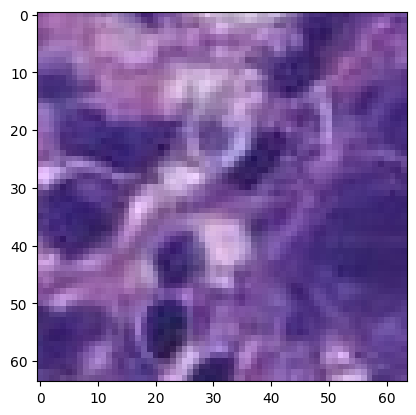

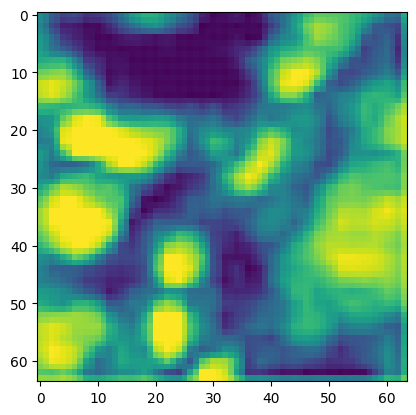

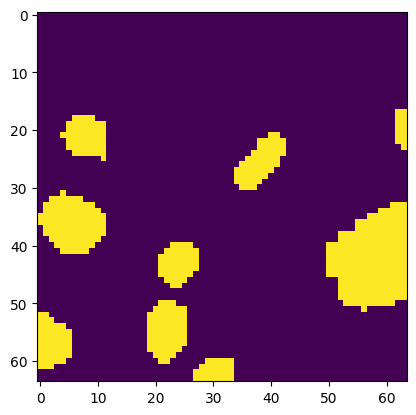

epoch 1/2, step 2420/6250, loss 0.16500487327575683, acc 0.84130859375, time 0:37:46.011823
epoch 1/2, step 2440/6250, loss 0.16544663086533545, acc 0.859619140625, time 0:38:03.125931
epoch 1/2, step 2460/6250, loss 0.1651631034910679, acc 0.8358001708984375, time 0:38:20.690224
epoch 1/2, step 2480/6250, loss 0.16863690242171286, acc 0.848297119140625, time 0:38:38.221178
epoch 1/2, step 2500/6250, loss 0.16803475394845008, acc 0.845458984375, time 0:38:55.871724
epoch 1/2, step 2520/6250, loss 0.17035425901412965, acc 0.8628997802734375, time 0:39:12.945041
epoch 1/2, step 2540/6250, loss 0.1644924148917198, acc 0.8738784790039062, time 0:39:30.403444
epoch 1/2, step 2560/6250, loss 0.16834216564893723, acc 0.8435745239257812, time 0:39:47.647943
epoch 1/2, step 2580/6250, loss 0.16777387782931327, acc 0.8499832153320312, time 0:40:04.967949
epoch 1/2, step 2600/6250, loss 0.16539361849427223, acc 0.8226547241210938, time 0:40:22.101638


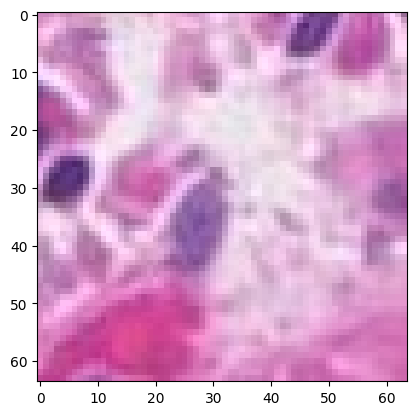

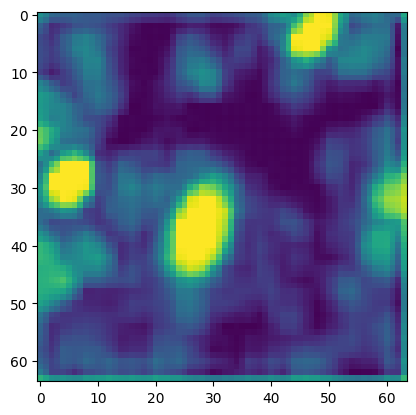

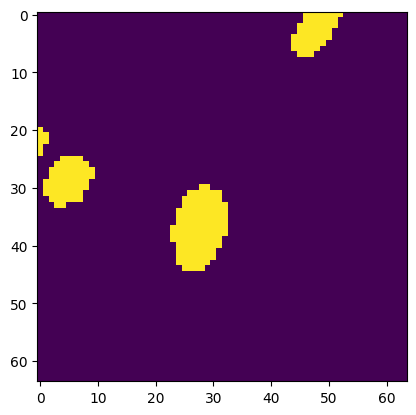

epoch 1/2, step 2620/6250, loss 0.17947969138622283, acc 0.843109130859375, time 0:40:40.062439
epoch 1/2, step 2640/6250, loss 0.16346903294324874, acc 0.8456268310546875, time 0:40:57.461474
epoch 1/2, step 2660/6250, loss 0.16499418020248413, acc 0.8427810668945312, time 0:41:14.937512
epoch 1/2, step 2680/6250, loss 0.16265340894460678, acc 0.8624801635742188, time 0:41:32.582214
epoch 1/2, step 2700/6250, loss 0.16496297642588614, acc 0.85467529296875, time 0:41:51.047711
epoch 1/2, step 2720/6250, loss 0.1655270829796791, acc 0.8358993530273438, time 0:42:11.859787
epoch 1/2, step 2740/6250, loss 0.16084399446845055, acc 0.828338623046875, time 0:42:30.618578
epoch 1/2, step 2760/6250, loss 0.15299739837646484, acc 0.8342742919921875, time 0:42:48.536788
epoch 1/2, step 2780/6250, loss 0.16417362801730634, acc 0.868804931640625, time 0:43:06.130762
epoch 1/2, step 2800/6250, loss 0.1643623374402523, acc 0.822906494140625, time 0:43:24.233308


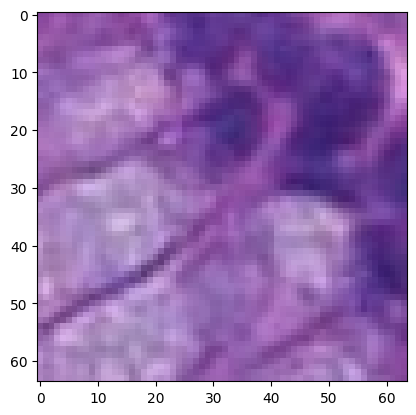

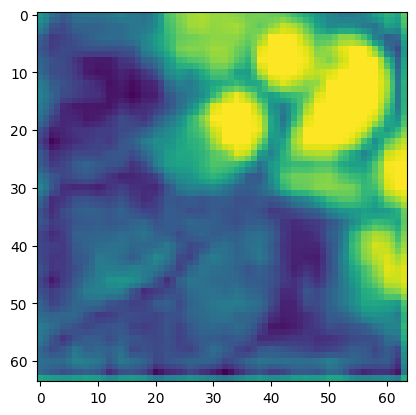

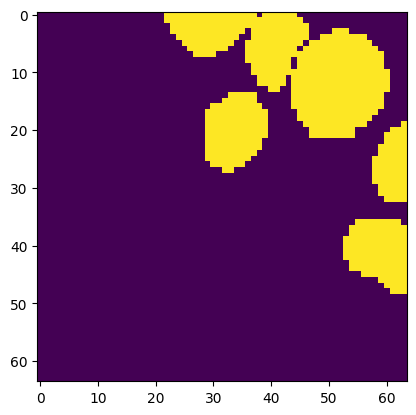

epoch 1/2, step 2820/6250, loss 0.16606504432857036, acc 0.8053207397460938, time 0:43:42.220789
epoch 1/2, step 2840/6250, loss 0.16475431472063065, acc 0.8358917236328125, time 0:43:59.841725
epoch 1/2, step 2860/6250, loss 0.16290400698781013, acc 0.841705322265625, time 0:44:17.185817
epoch 1/2, step 2880/6250, loss 0.16837795972824096, acc 0.81781005859375, time 0:44:34.438428
epoch 1/2, step 2900/6250, loss 0.15823263302445412, acc 0.825592041015625, time 0:44:52.003568
epoch 1/2, step 2920/6250, loss 0.17116836681962014, acc 0.8374710083007812, time 0:45:09.791375
epoch 1/2, step 2940/6250, loss 0.16443497836589813, acc 0.8226547241210938, time 0:45:27.535572
epoch 1/2, step 2960/6250, loss 0.1712084747850895, acc 0.8065185546875, time 0:45:44.724808
epoch 1/2, step 2980/6250, loss 0.16859357580542564, acc 0.8394851684570312, time 0:46:01.912789
epoch 1/2, step 3000/6250, loss 0.1662105403840542, acc 0.8382949829101562, time 0:46:19.157123


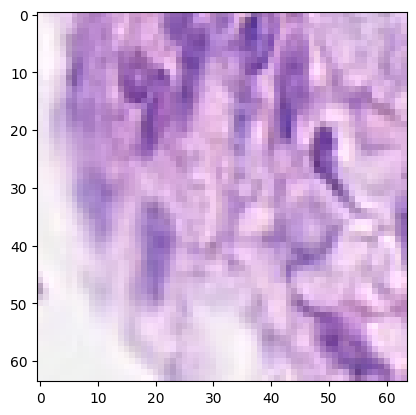

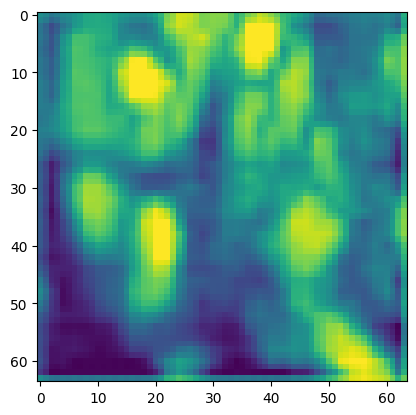

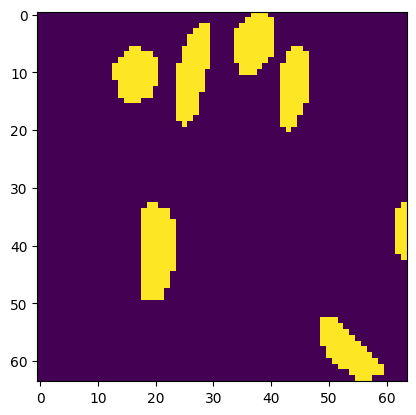

epoch 1/2, step 3020/6250, loss 0.1591247834265232, acc 0.8646240234375, time 0:46:36.698874
epoch 1/2, step 3040/6250, loss 0.1558522865176201, acc 0.8592453002929688, time 0:46:54.019782
epoch 1/2, step 3060/6250, loss 0.16605986207723616, acc 0.8688507080078125, time 0:47:11.523548
epoch 1/2, step 3080/6250, loss 0.1638958342373371, acc 0.8465499877929688, time 0:47:28.476233
epoch 1/2, step 3100/6250, loss 0.16545219197869301, acc 0.8812637329101562, time 0:47:45.784749
epoch 1/2, step 3120/6250, loss 0.16818021535873412, acc 0.8308944702148438, time 0:48:02.966207
epoch 1/2, step 3140/6250, loss 0.16330963224172593, acc 0.8441085815429688, time 0:48:20.249725
epoch 1/2, step 3160/6250, loss 0.16897565945982934, acc 0.8841705322265625, time 0:48:37.682953
epoch 1/2, step 3180/6250, loss 0.16559474766254426, acc 0.8122634887695312, time 0:48:55.031839
epoch 1/2, step 3200/6250, loss 0.16770580038428307, acc 0.8284835815429688, time 0:49:12.346679


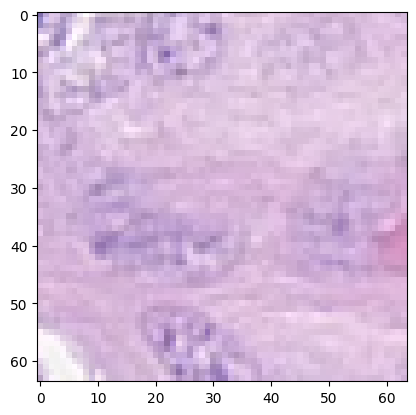

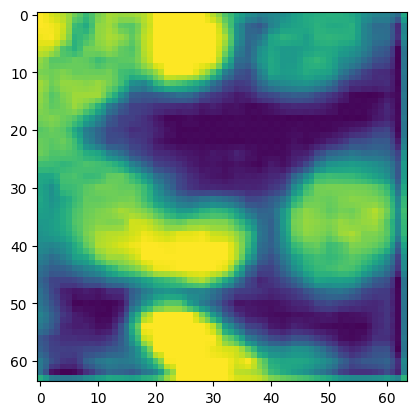

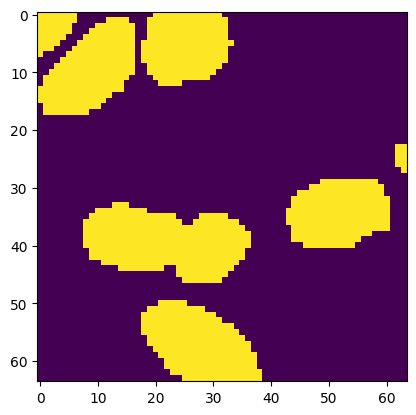

epoch 1/2, step 3220/6250, loss 0.16646160036325455, acc 0.8634109497070312, time 0:49:30.638103
epoch 1/2, step 3240/6250, loss 0.17090726792812347, acc 0.8302688598632812, time 0:49:48.010291
epoch 1/2, step 3260/6250, loss 0.16073678880929948, acc 0.8253021240234375, time 0:50:05.387275
epoch 1/2, step 3280/6250, loss 0.15861776471138, acc 0.8588485717773438, time 0:50:22.917357
epoch 1/2, step 3300/6250, loss 0.16778116598725318, acc 0.8383255004882812, time 0:50:40.493732
epoch 1/2, step 3320/6250, loss 0.1600629985332489, acc 0.8478546142578125, time 0:50:57.874057
epoch 1/2, step 3340/6250, loss 0.15683030262589454, acc 0.8302459716796875, time 0:51:15.410009
epoch 1/2, step 3360/6250, loss 0.15819041207432746, acc 0.8478469848632812, time 0:51:32.941893
epoch 1/2, step 3380/6250, loss 0.16574756056070328, acc 0.8426284790039062, time 0:51:50.338321
epoch 1/2, step 3400/6250, loss 0.15959873795509338, acc 0.8278732299804688, time 0:52:10.211298


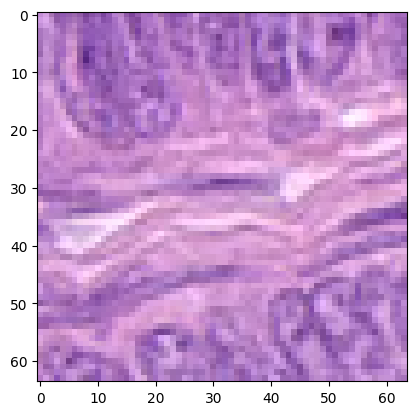

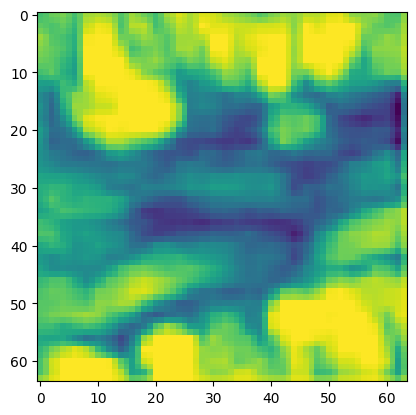

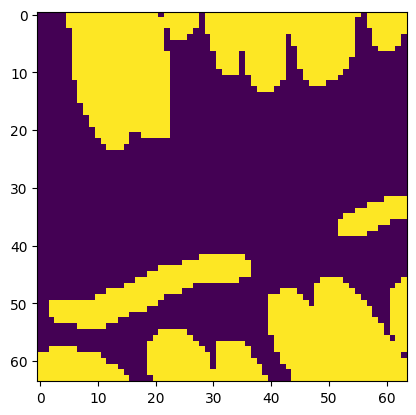

epoch 1/2, step 3420/6250, loss 0.1680703081190586, acc 0.8569793701171875, time 0:52:30.261111
epoch 1/2, step 3440/6250, loss 0.15809526070952415, acc 0.8144378662109375, time 0:52:47.448065
epoch 1/2, step 3460/6250, loss 0.15973615273833275, acc 0.8318557739257812, time 0:53:04.697735
epoch 1/2, step 3480/6250, loss 0.1606119118630886, acc 0.843597412109375, time 0:53:22.144968
epoch 1/2, step 3500/6250, loss 0.16410180032253266, acc 0.8351974487304688, time 0:53:39.618431
epoch 1/2, step 3520/6250, loss 0.15752024203538895, acc 0.8347625732421875, time 0:53:57.131926
epoch 1/2, step 3540/6250, loss 0.16241835355758666, acc 0.852935791015625, time 0:54:14.800726
epoch 1/2, step 3560/6250, loss 0.160797780752182, acc 0.8180084228515625, time 0:54:32.022541
epoch 1/2, step 3580/6250, loss 0.15544172711670398, acc 0.7687454223632812, time 0:54:49.369194
epoch 1/2, step 3600/6250, loss 0.1651976265013218, acc 0.8670730590820312, time 0:55:06.972758


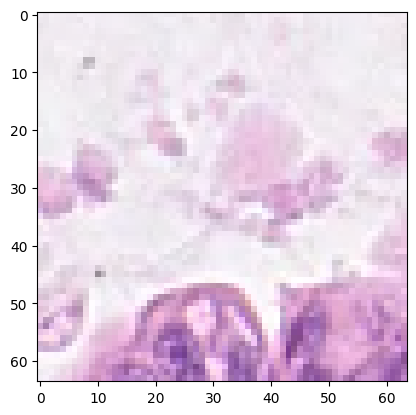

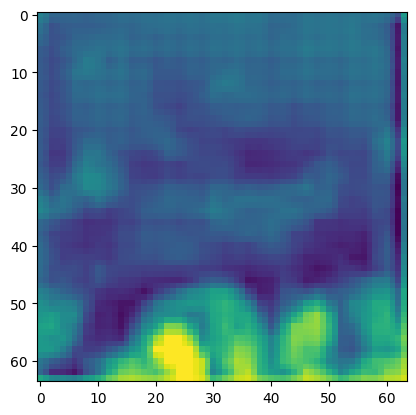

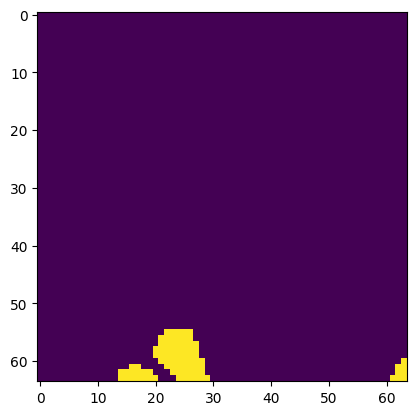

epoch 1/2, step 3620/6250, loss 0.16830605417490005, acc 0.8001937866210938, time 0:55:24.739071
epoch 1/2, step 3640/6250, loss 0.16225021407008172, acc 0.8182144165039062, time 0:55:41.922964
epoch 1/2, step 3660/6250, loss 0.15791938602924346, acc 0.8372650146484375, time 0:55:59.539468
epoch 1/2, step 3680/6250, loss 0.16582388877868653, acc 0.8410568237304688, time 0:56:16.696478
epoch 1/2, step 3700/6250, loss 0.16381484940648078, acc 0.8274612426757812, time 0:56:34.187857
epoch 1/2, step 3720/6250, loss 0.16049507707357408, acc 0.8449554443359375, time 0:56:51.557663
epoch 1/2, step 3740/6250, loss 0.15950582325458526, acc 0.866302490234375, time 0:57:08.717210
epoch 1/2, step 3760/6250, loss 0.156072386354208, acc 0.8446273803710938, time 0:57:26.076177
epoch 1/2, step 3780/6250, loss 0.15731030516326427, acc 0.8584976196289062, time 0:57:43.304262
epoch 1/2, step 3800/6250, loss 0.1557353511452675, acc 0.812042236328125, time 0:58:00.572778


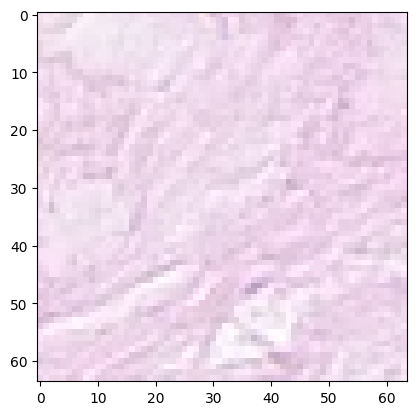

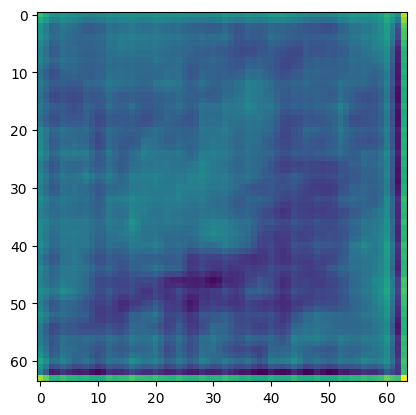

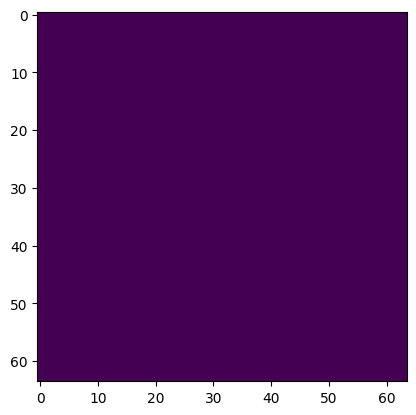

epoch 1/2, step 3820/6250, loss 0.16647605672478677, acc 0.8587570190429688, time 0:58:18.583189
epoch 1/2, step 3840/6250, loss 0.1671433724462986, acc 0.8245086669921875, time 0:58:35.966990
epoch 1/2, step 3860/6250, loss 0.15977075695991516, acc 0.847381591796875, time 0:58:55.167019
epoch 1/2, step 3880/6250, loss 0.16538955941796302, acc 0.8172073364257812, time 0:59:12.779662
epoch 1/2, step 3900/6250, loss 0.1532328948378563, acc 0.8356475830078125, time 0:59:30.662662
epoch 1/2, step 3920/6250, loss 0.16430269442498685, acc 0.8501968383789062, time 0:59:47.799892
epoch 1/2, step 3940/6250, loss 0.16197827756404876, acc 0.8379287719726562, time 1:00:04.991963
epoch 1/2, step 3960/6250, loss 0.15887620225548743, acc 0.792327880859375, time 1:00:22.266870
epoch 1/2, step 3980/6250, loss 0.1540204431861639, acc 0.8636627197265625, time 1:00:39.345607
epoch 1/2, step 4000/6250, loss 0.16312686651945113, acc 0.8525390625, time 1:00:56.137343


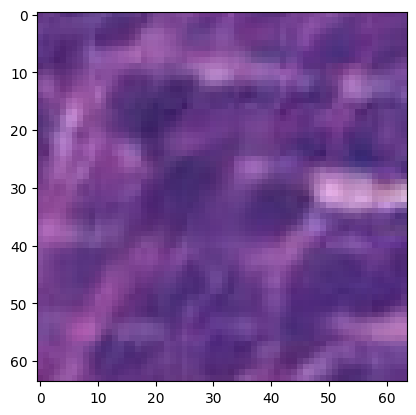

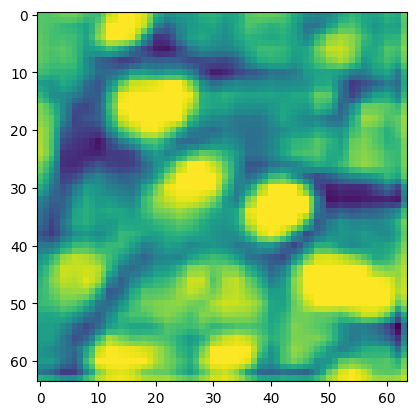

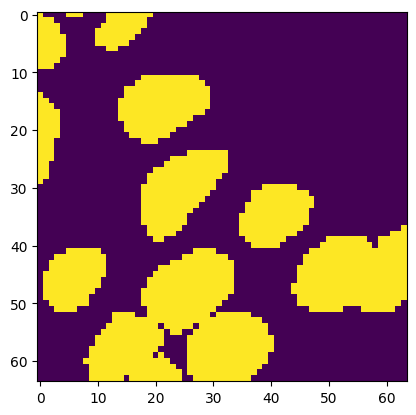

epoch 1/2, step 4020/6250, loss 0.16042395383119584, acc 0.8357772827148438, time 1:01:14.213204
epoch 1/2, step 4040/6250, loss 0.15635407716035843, acc 0.831787109375, time 1:01:31.679145
epoch 1/2, step 4060/6250, loss 0.15923393592238427, acc 0.8284225463867188, time 1:01:48.997477
epoch 1/2, step 4080/6250, loss 0.15478148609399794, acc 0.813201904296875, time 1:02:06.505656
epoch 1/2, step 4100/6250, loss 0.16298961415886878, acc 0.8156280517578125, time 1:02:23.245334
epoch 1/2, step 4120/6250, loss 0.1584266535937786, acc 0.829010009765625, time 1:02:40.743249
epoch 1/2, step 4140/6250, loss 0.1549404576420784, acc 0.8340911865234375, time 1:02:58.202671
epoch 1/2, step 4160/6250, loss 0.15719765201210975, acc 0.7954025268554688, time 1:03:15.896988
epoch 1/2, step 4180/6250, loss 0.16362014338374137, acc 0.8341445922851562, time 1:03:33.409394
epoch 1/2, step 4200/6250, loss 0.16086122319102286, acc 0.8176193237304688, time 1:03:50.530847


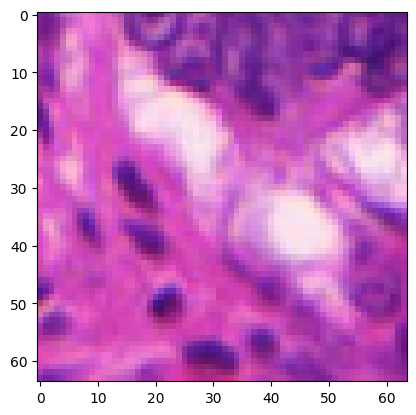

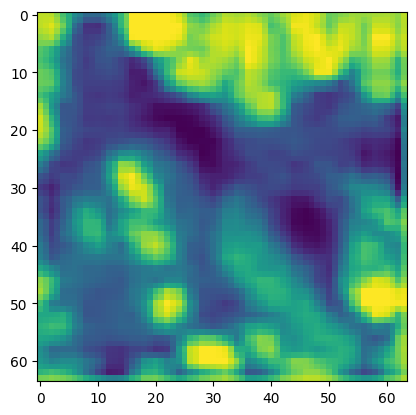

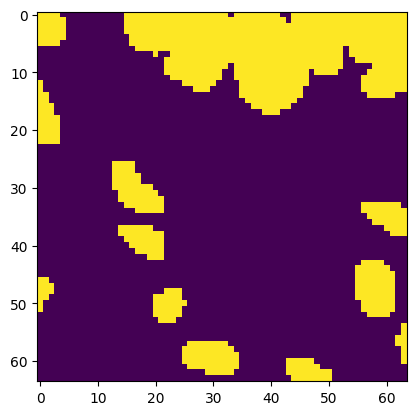

epoch 1/2, step 4220/6250, loss 0.15575265511870384, acc 0.8424606323242188, time 1:04:08.338300
epoch 1/2, step 4240/6250, loss 0.1682268813252449, acc 0.8528518676757812, time 1:04:25.142843
epoch 1/2, step 4260/6250, loss 0.1565713942050934, acc 0.8520278930664062, time 1:04:42.184362
epoch 1/2, step 4280/6250, loss 0.1603941187262535, acc 0.8544387817382812, time 1:04:59.471591
epoch 1/2, step 4300/6250, loss 0.15588654726743698, acc 0.8466415405273438, time 1:05:16.573577
epoch 1/2, step 4320/6250, loss 0.15662556514143944, acc 0.8444290161132812, time 1:05:33.651255
epoch 1/2, step 4340/6250, loss 0.15667657516896724, acc 0.8763504028320312, time 1:05:50.731071
epoch 1/2, step 4360/6250, loss 0.16053075082600116, acc 0.8231430053710938, time 1:06:07.710236
epoch 1/2, step 4380/6250, loss 0.1557675775140524, acc 0.837188720703125, time 1:06:24.645398
epoch 1/2, step 4400/6250, loss 0.15453916788101196, acc 0.8339614868164062, time 1:06:42.098228


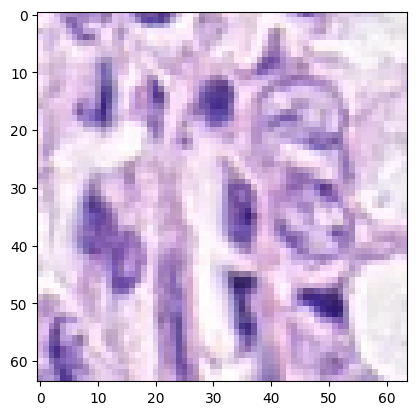

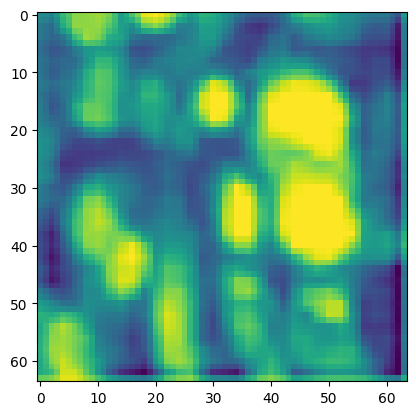

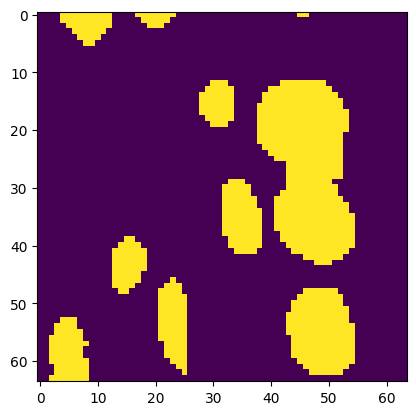

epoch 1/2, step 4420/6250, loss 0.15631234720349313, acc 0.82635498046875, time 1:06:59.709595
epoch 1/2, step 4440/6250, loss 0.1527821198105812, acc 0.871185302734375, time 1:07:16.857374
epoch 1/2, step 4460/6250, loss 0.1538183569908142, acc 0.8319244384765625, time 1:07:33.568331
epoch 1/2, step 4480/6250, loss 0.16387771628797054, acc 0.823333740234375, time 1:07:51.130283
epoch 1/2, step 4500/6250, loss 0.15915969908237457, acc 0.8677978515625, time 1:08:08.342789
epoch 1/2, step 4520/6250, loss 0.15578225925564765, acc 0.8044204711914062, time 1:08:25.632751
epoch 1/2, step 4540/6250, loss 0.15975735932588578, acc 0.8422393798828125, time 1:08:42.855597
epoch 1/2, step 4560/6250, loss 0.15276908800005912, acc 0.8551025390625, time 1:08:59.921671
epoch 1/2, step 4580/6250, loss 0.1547774810343981, acc 0.841217041015625, time 1:09:16.981618
epoch 1/2, step 4600/6250, loss 0.15240833684802055, acc 0.854736328125, time 1:09:34.176559


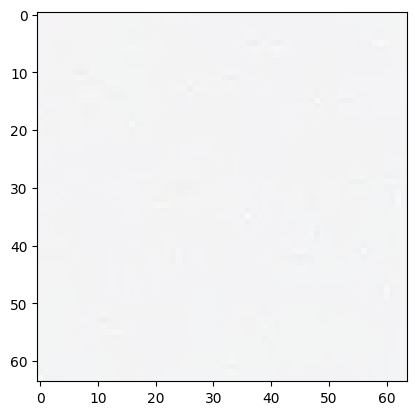

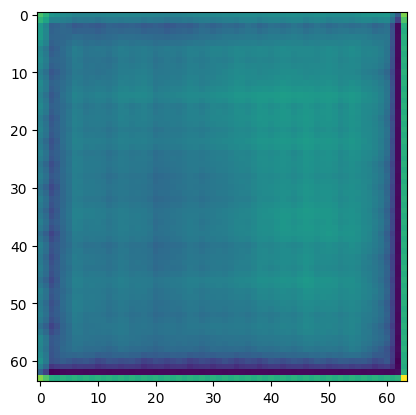

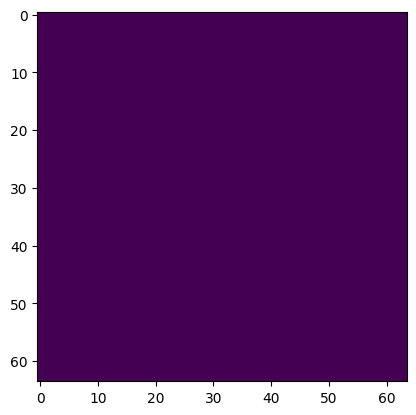

epoch 1/2, step 4620/6250, loss 0.15696528926491737, acc 0.849609375, time 1:09:52.133619
epoch 1/2, step 4640/6250, loss 0.1618935815989971, acc 0.8348007202148438, time 1:10:09.381310
epoch 1/2, step 4660/6250, loss 0.1583841025829315, acc 0.8370208740234375, time 1:10:26.441522
epoch 1/2, step 4680/6250, loss 0.15669020116329194, acc 0.8355178833007812, time 1:10:43.595588
epoch 1/2, step 4700/6250, loss 0.15033229291439057, acc 0.8324813842773438, time 1:11:00.802607
epoch 1/2, step 4720/6250, loss 0.15566364899277688, acc 0.842193603515625, time 1:11:17.986113
epoch 1/2, step 4740/6250, loss 0.15336197540163993, acc 0.8496170043945312, time 1:11:35.377631
epoch 1/2, step 4760/6250, loss 0.15425675213336945, acc 0.8444900512695312, time 1:11:52.497727
epoch 1/2, step 4780/6250, loss 0.15236092172563076, acc 0.883758544921875, time 1:12:09.630015
epoch 1/2, step 4800/6250, loss 0.16894579753279687, acc 0.8609390258789062, time 1:12:26.528642


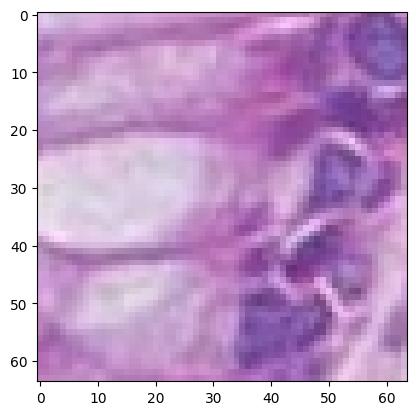

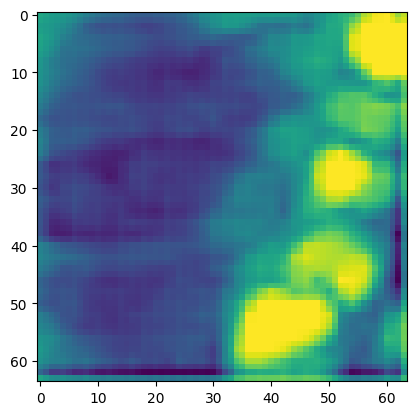

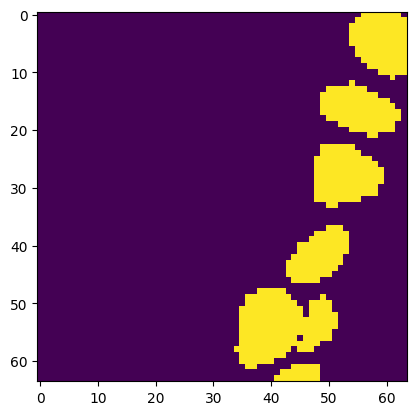

epoch 1/2, step 4820/6250, loss 0.15260996632277965, acc 0.8559341430664062, time 1:12:43.942595
epoch 1/2, step 4840/6250, loss 0.1599503442645073, acc 0.8537063598632812, time 1:13:00.689337
epoch 1/2, step 4860/6250, loss 0.15657647289335727, acc 0.83941650390625, time 1:13:17.891220
epoch 1/2, step 4880/6250, loss 0.161581152677536, acc 0.85528564453125, time 1:13:35.406481
epoch 1/2, step 4900/6250, loss 0.15421794801950456, acc 0.8583450317382812, time 1:13:52.626236
epoch 1/2, step 4920/6250, loss 0.15314676873385907, acc 0.88470458984375, time 1:14:09.630092
epoch 1/2, step 4940/6250, loss 0.16565118506550788, acc 0.8366165161132812, time 1:14:26.890671
epoch 1/2, step 4960/6250, loss 0.15153865627944468, acc 0.866729736328125, time 1:14:43.712367
epoch 1/2, step 4980/6250, loss 0.1493576504290104, acc 0.8348464965820312, time 1:15:01.070416
epoch 1/2, step 5000/6250, loss 0.1642596147954464, acc 0.8698501586914062, time 1:15:18.443636


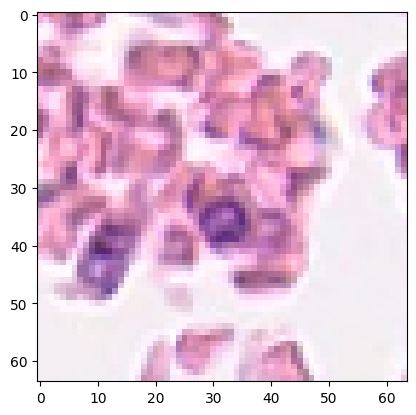

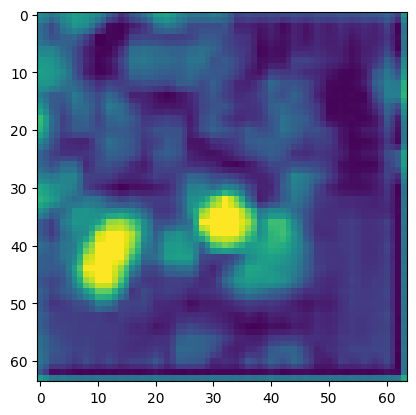

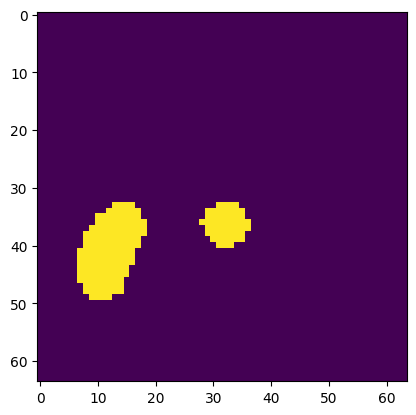

epoch 1/2, step 5020/6250, loss 0.15477817133069038, acc 0.8512649536132812, time 1:15:36.425587
epoch 1/2, step 5040/6250, loss 0.164536801725626, acc 0.84967041015625, time 1:15:53.779308
epoch 1/2, step 5060/6250, loss 0.16251092441380025, acc 0.845550537109375, time 1:16:11.076476
epoch 1/2, step 5080/6250, loss 0.14765511751174926, acc 0.8481292724609375, time 1:16:28.498816
epoch 1/2, step 5100/6250, loss 0.15811707228422164, acc 0.8216323852539062, time 1:16:45.604130
epoch 1/2, step 5120/6250, loss 0.16632231511175632, acc 0.8341217041015625, time 1:17:02.913225
epoch 1/2, step 5140/6250, loss 0.16000672429800034, acc 0.836883544921875, time 1:17:20.792412
epoch 1/2, step 5160/6250, loss 0.15134359151124954, acc 0.8684921264648438, time 1:17:38.254071
epoch 1/2, step 5180/6250, loss 0.15845063403248788, acc 0.8401718139648438, time 1:17:54.953248
epoch 1/2, step 5200/6250, loss 0.15637813732028008, acc 0.8493728637695312, time 1:18:12.540954


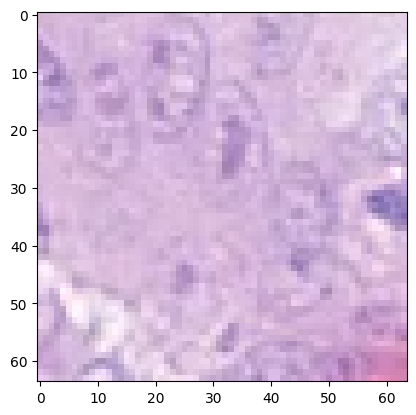

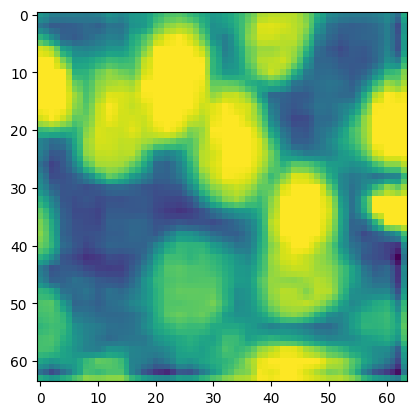

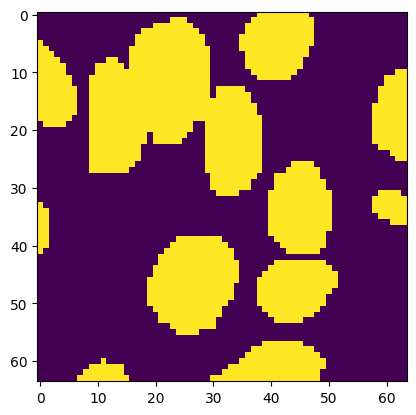

epoch 1/2, step 5220/6250, loss 0.15174221992492676, acc 0.8397750854492188, time 1:18:31.211941
epoch 1/2, step 5240/6250, loss 0.164496111869812, acc 0.8257675170898438, time 1:18:49.046860
epoch 1/2, step 5260/6250, loss 0.16202778443694116, acc 0.8597946166992188, time 1:19:06.366010
epoch 1/2, step 5280/6250, loss 0.15428040474653243, acc 0.8800277709960938, time 1:19:23.420096
epoch 1/2, step 5300/6250, loss 0.15484700091183184, acc 0.857818603515625, time 1:19:40.657729
epoch 1/2, step 5320/6250, loss 0.1543302208185196, acc 0.8300399780273438, time 1:19:57.743006
epoch 1/2, step 5340/6250, loss 0.1505043089389801, acc 0.8331756591796875, time 1:20:15.153584
epoch 1/2, step 5360/6250, loss 0.15648992881178855, acc 0.8266143798828125, time 1:20:32.616748
epoch 1/2, step 5380/6250, loss 0.1511898420751095, acc 0.8361663818359375, time 1:20:49.816033
epoch 1/2, step 5400/6250, loss 0.1526310693472624, acc 0.8481292724609375, time 1:21:07.068465


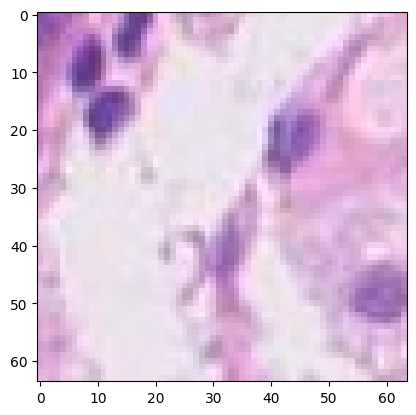

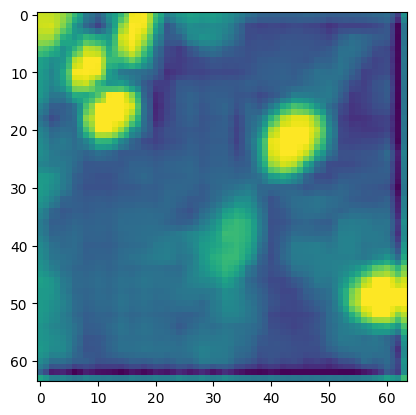

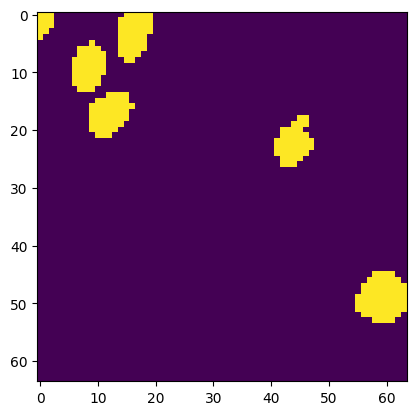

epoch 1/2, step 5420/6250, loss 0.16005657687783242, acc 0.86419677734375, time 1:21:24.958164
epoch 1/2, step 5440/6250, loss 0.1497714463621378, acc 0.8327255249023438, time 1:21:42.009667
epoch 1/2, step 5460/6250, loss 0.1525459833443165, acc 0.8208999633789062, time 1:21:59.489776
epoch 1/2, step 5480/6250, loss 0.1578833594918251, acc 0.8548431396484375, time 1:22:16.515723
epoch 1/2, step 5500/6250, loss 0.15031616277992726, acc 0.8336181640625, time 1:22:33.531820
epoch 1/2, step 5520/6250, loss 0.15404197946190834, acc 0.8299026489257812, time 1:22:50.442380
epoch 1/2, step 5540/6250, loss 0.15364236906170844, acc 0.8404083251953125, time 1:23:07.494977
epoch 1/2, step 5560/6250, loss 0.15863691717386247, acc 0.8396682739257812, time 1:23:24.521498
epoch 1/2, step 5580/6250, loss 0.155929633975029, acc 0.8477783203125, time 1:23:41.606130
epoch 1/2, step 5600/6250, loss 0.15848368108272554, acc 0.8483047485351562, time 1:23:58.352917


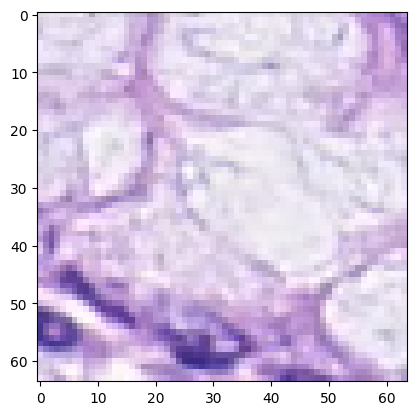

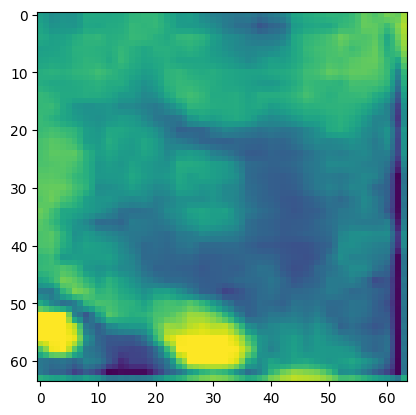

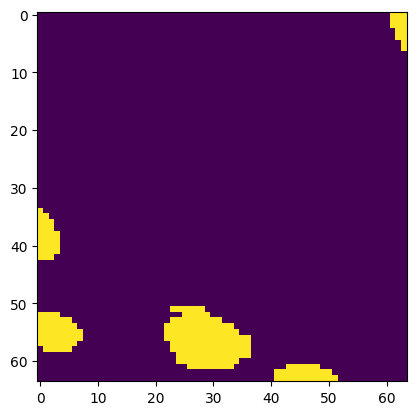

epoch 1/2, step 5620/6250, loss 0.14644681997597217, acc 0.8405914306640625, time 1:24:15.737930
epoch 1/2, step 5640/6250, loss 0.1611570157110691, acc 0.8369598388671875, time 1:24:32.903831
epoch 1/2, step 5660/6250, loss 0.15396202690899372, acc 0.8475341796875, time 1:24:49.969792
epoch 1/2, step 5680/6250, loss 0.15289219915866853, acc 0.8465423583984375, time 1:25:06.809588
epoch 1/2, step 5700/6250, loss 0.14878675937652588, acc 0.865020751953125, time 1:25:24.305310
epoch 1/2, step 5720/6250, loss 0.15317331552505492, acc 0.8729019165039062, time 1:25:41.611157
epoch 1/2, step 5740/6250, loss 0.14743213579058648, acc 0.8237686157226562, time 1:25:58.988786
epoch 1/2, step 5760/6250, loss 0.1531421348452568, acc 0.8250808715820312, time 1:26:16.538488
epoch 1/2, step 5780/6250, loss 0.15282459706068038, acc 0.8301773071289062, time 1:26:33.696718
epoch 1/2, step 5800/6250, loss 0.1467645913362503, acc 0.8351974487304688, time 1:26:50.923646


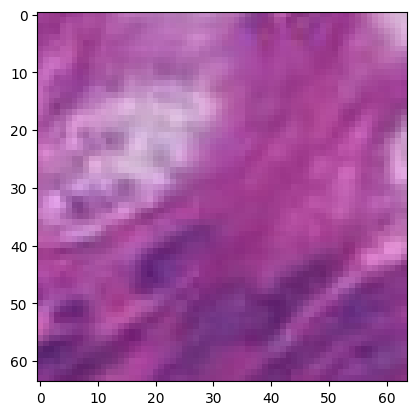

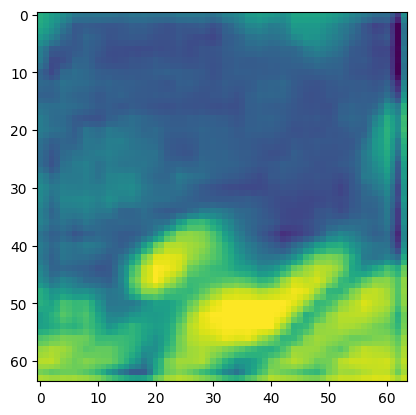

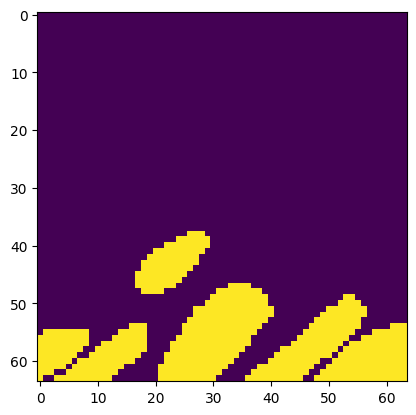

epoch 1/2, step 5820/6250, loss 0.15660967901349068, acc 0.8480300903320312, time 1:27:08.369526
epoch 1/2, step 5840/6250, loss 0.14641685150563716, acc 0.8462066650390625, time 1:27:25.204132
epoch 1/2, step 5860/6250, loss 0.15385486073791982, acc 0.8294448852539062, time 1:27:42.663835
epoch 1/2, step 5880/6250, loss 0.1503785066306591, acc 0.84295654296875, time 1:27:59.827148
epoch 1/2, step 5900/6250, loss 0.15014405138790607, acc 0.8507461547851562, time 1:28:17.012915
epoch 1/2, step 5920/6250, loss 0.15524897798895837, acc 0.8431930541992188, time 1:28:34.474579
epoch 1/2, step 5940/6250, loss 0.15603849813342094, acc 0.8461227416992188, time 1:28:51.750458
epoch 1/2, step 5960/6250, loss 0.1573735125362873, acc 0.858184814453125, time 1:29:08.972992
epoch 1/2, step 5980/6250, loss 0.1490008320659399, acc 0.8287353515625, time 1:29:26.384506
epoch 1/2, step 6000/6250, loss 0.15765094757080078, acc 0.8489151000976562, time 1:29:43.418080


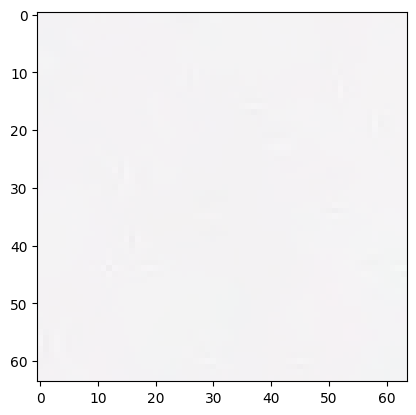

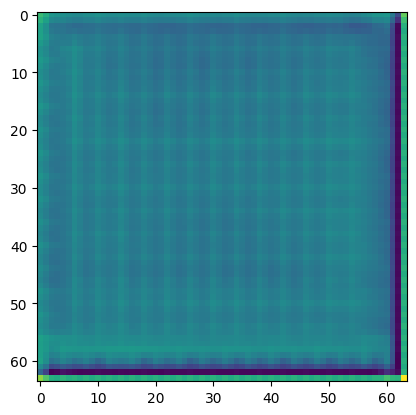

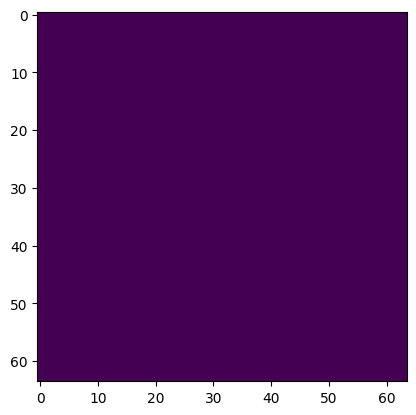

epoch 1/2, step 6020/6250, loss 0.15735408924520017, acc 0.8314056396484375, time 1:30:01.207181
epoch 1/2, step 6040/6250, loss 0.1484924118965864, acc 0.8223419189453125, time 1:30:19.446488
epoch 1/2, step 6060/6250, loss 0.1570322785526514, acc 0.8569183349609375, time 1:30:37.958361
epoch 1/2, step 6080/6250, loss 0.1512319825589657, acc 0.8425521850585938, time 1:30:55.140439
epoch 1/2, step 6100/6250, loss 0.14784881100058556, acc 0.8157577514648438, time 1:31:12.089907
epoch 1/2, step 6120/6250, loss 0.1505650207400322, acc 0.844390869140625, time 1:31:29.559529
epoch 1/2, step 6140/6250, loss 0.14703761488199235, acc 0.8194580078125, time 1:31:46.662402
epoch 1/2, step 6160/6250, loss 0.15727247670292854, acc 0.8098678588867188, time 1:32:04.005961
epoch 1/2, step 6180/6250, loss 0.161694673076272, acc 0.8227615356445312, time 1:32:21.014399
epoch 1/2, step 6200/6250, loss 0.15808025375008583, acc 0.8753814697265625, time 1:32:37.962033


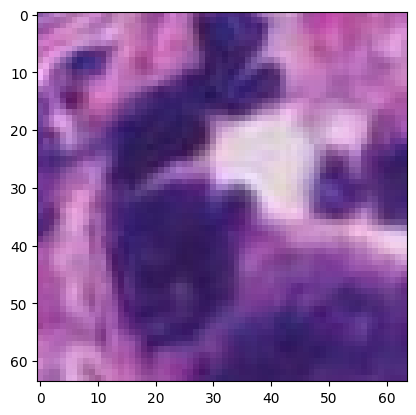

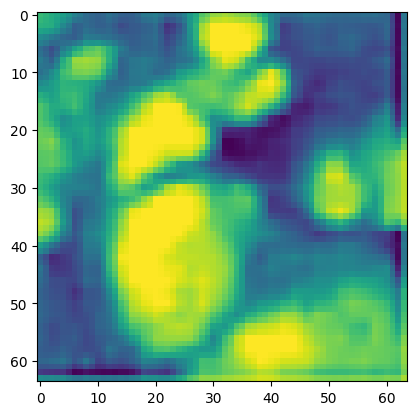

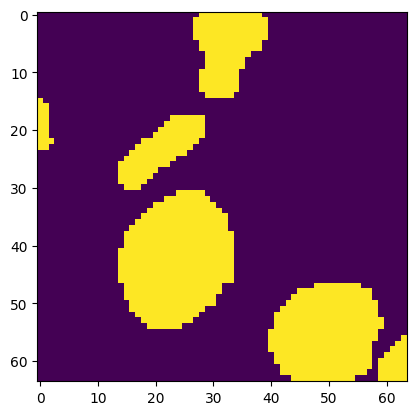

epoch 1/2, step 6220/6250, loss 0.14576266184449196, acc 0.8600311279296875, time 1:32:57.587116
epoch 1/2, step 6240/6250, loss 0.14905158206820487, acc 0.8744049072265625, time 1:33:15.613205
epoch 2/2, step 20/6250, loss 0.14767540954053401, acc 0.8500213623046875, time 1:33:42.196480
epoch 2/2, step 40/6250, loss 0.144095928221941, acc 0.8517074584960938, time 1:33:59.283150
epoch 2/2, step 60/6250, loss 0.15639911741018295, acc 0.8372268676757812, time 1:34:16.514691
epoch 2/2, step 80/6250, loss 0.15738779306411743, acc 0.8550262451171875, time 1:34:33.843775
epoch 2/2, step 100/6250, loss 0.15049680657684802, acc 0.8442611694335938, time 1:34:51.340378
epoch 2/2, step 120/6250, loss 0.15994803756475448, acc 0.8323440551757812, time 1:35:08.667700
epoch 2/2, step 140/6250, loss 0.1536420501768589, acc 0.8657760620117188, time 1:35:25.999704
epoch 2/2, step 160/6250, loss 0.15682456642389297, acc 0.8036575317382812, time 1:35:43.175977
epoch 2/2, step 180/6250, loss 0.154286763817

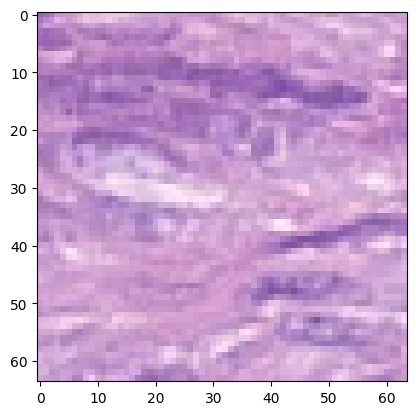

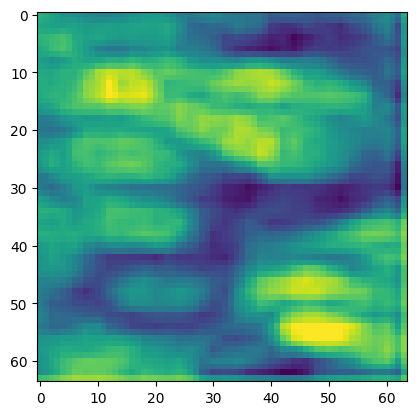

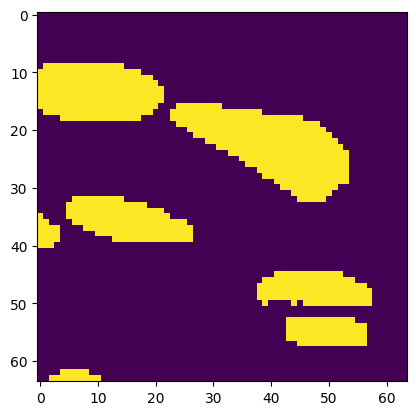

epoch 2/2, step 220/6250, loss 0.1563075602054596, acc 0.869537353515625, time 1:36:35.381380
epoch 2/2, step 240/6250, loss 0.1522873505949974, acc 0.85723876953125, time 1:36:52.392867
epoch 2/2, step 260/6250, loss 0.14279625602066517, acc 0.8458404541015625, time 1:37:08.898023
epoch 2/2, step 280/6250, loss 0.1503298193216324, acc 0.8760986328125, time 1:37:26.408018
epoch 2/2, step 300/6250, loss 0.1463688388466835, acc 0.8723220825195312, time 1:37:43.690049
epoch 2/2, step 320/6250, loss 0.15696902573108673, acc 0.8466339111328125, time 1:38:00.804254
epoch 2/2, step 340/6250, loss 0.1491405550390482, acc 0.8463897705078125, time 1:38:18.081808
epoch 2/2, step 360/6250, loss 0.1477002792060375, acc 0.81646728515625, time 1:38:35.245498
epoch 2/2, step 380/6250, loss 0.15275706797838212, acc 0.8211669921875, time 1:38:52.469322
epoch 2/2, step 400/6250, loss 0.14869020208716394, acc 0.8479843139648438, time 1:39:09.656099


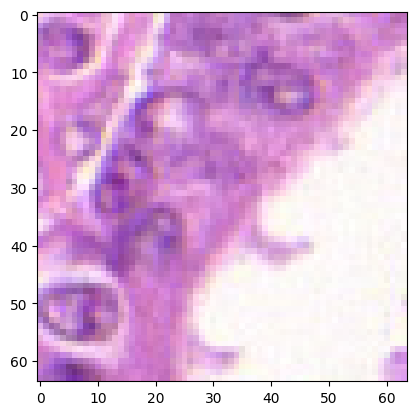

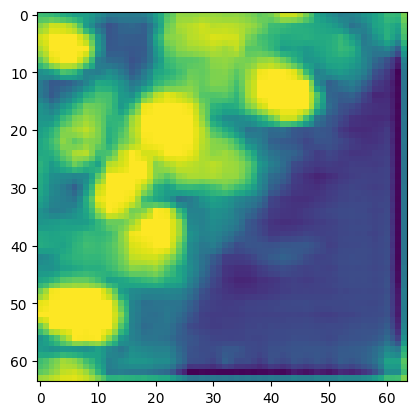

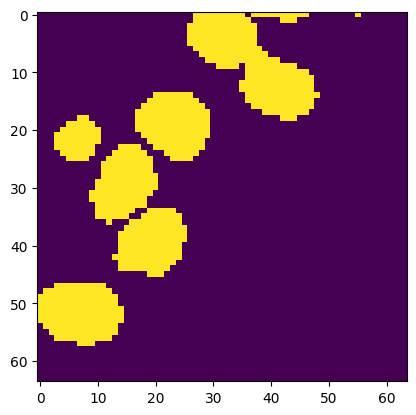

epoch 2/2, step 420/6250, loss 0.14768198542296887, acc 0.8310775756835938, time 1:39:27.657812
epoch 2/2, step 440/6250, loss 0.1477542981505394, acc 0.8541336059570312, time 1:39:44.691987
epoch 2/2, step 460/6250, loss 0.15117931142449378, acc 0.8262710571289062, time 1:40:01.588942
epoch 2/2, step 480/6250, loss 0.15786623097956182, acc 0.854736328125, time 1:40:18.637542
epoch 2/2, step 500/6250, loss 0.14915196262300015, acc 0.8555984497070312, time 1:40:35.883446
epoch 2/2, step 520/6250, loss 0.15387104600667953, acc 0.8114242553710938, time 1:40:53.068408
epoch 2/2, step 540/6250, loss 0.1606936015188694, acc 0.8739776611328125, time 1:41:10.359102
epoch 2/2, step 560/6250, loss 0.15264862701296805, acc 0.8468475341796875, time 1:41:27.590923
epoch 2/2, step 580/6250, loss 0.1523790467530489, acc 0.8371963500976562, time 1:41:44.280143
epoch 2/2, step 600/6250, loss 0.14913030937314034, acc 0.8018112182617188, time 1:42:03.405157


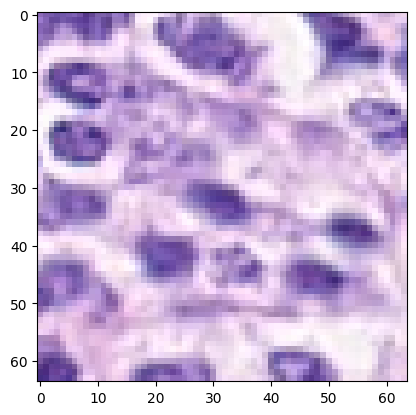

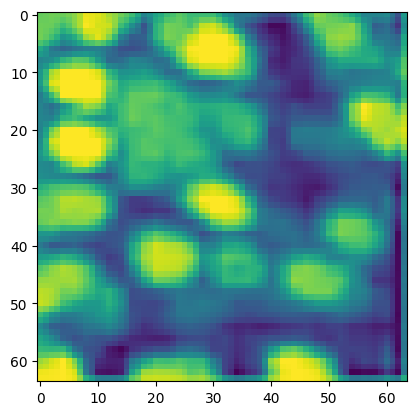

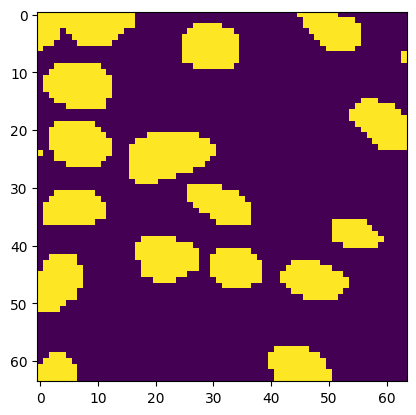

epoch 2/2, step 620/6250, loss 0.14499237835407258, acc 0.8489456176757812, time 1:42:22.386214
epoch 2/2, step 640/6250, loss 0.14895060025155543, acc 0.8105316162109375, time 1:42:39.479987
epoch 2/2, step 660/6250, loss 0.1510632485151291, acc 0.81695556640625, time 1:42:56.745933
epoch 2/2, step 680/6250, loss 0.1465436801314354, acc 0.86993408203125, time 1:43:14.492965
epoch 2/2, step 700/6250, loss 0.15632159858942032, acc 0.8041000366210938, time 1:43:32.329628
epoch 2/2, step 720/6250, loss 0.15331060402095317, acc 0.833465576171875, time 1:43:48.994295
epoch 2/2, step 740/6250, loss 0.15231481716036796, acc 0.8436660766601562, time 1:44:05.803759
epoch 2/2, step 760/6250, loss 0.14314167462289334, acc 0.82647705078125, time 1:44:23.018920
epoch 2/2, step 780/6250, loss 0.15593640729784966, acc 0.7937164306640625, time 1:44:40.229428
epoch 2/2, step 800/6250, loss 0.15459033586084842, acc 0.8279190063476562, time 1:44:57.604869


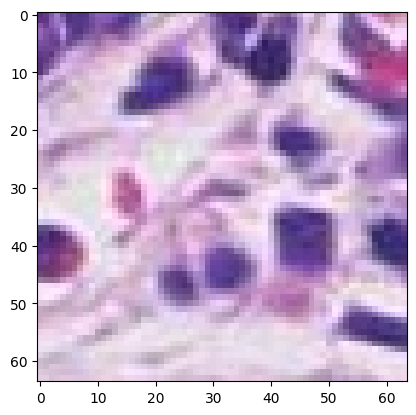

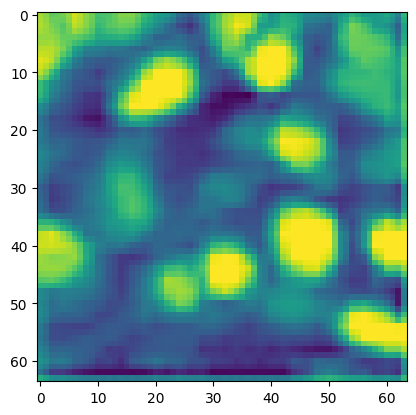

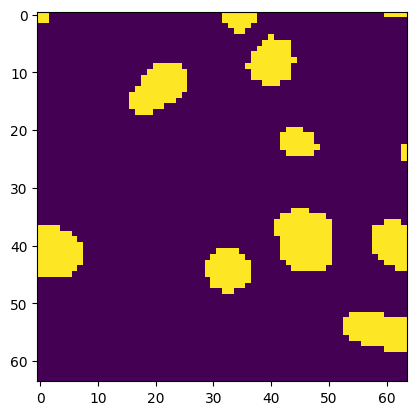

epoch 2/2, step 820/6250, loss 0.14513610824942588, acc 0.868316650390625, time 1:45:16.104232
epoch 2/2, step 840/6250, loss 0.15474259480834007, acc 0.847259521484375, time 1:45:33.678641
epoch 2/2, step 860/6250, loss 0.14811167418956755, acc 0.8506011962890625, time 1:45:50.930785
epoch 2/2, step 880/6250, loss 0.14606950394809246, acc 0.8458480834960938, time 1:46:07.906954
epoch 2/2, step 900/6250, loss 0.14641792513430119, acc 0.8291549682617188, time 1:46:25.038591
epoch 2/2, step 920/6250, loss 0.15004524663090707, acc 0.85430908203125, time 1:46:42.298588
epoch 2/2, step 940/6250, loss 0.14199444577097892, acc 0.8499603271484375, time 1:46:59.750610
epoch 2/2, step 960/6250, loss 0.14979244247078896, acc 0.8075485229492188, time 1:47:17.257163
epoch 2/2, step 980/6250, loss 0.1481181912124157, acc 0.8503952026367188, time 1:47:35.082145
epoch 2/2, step 1000/6250, loss 0.15117713958024978, acc 0.8245315551757812, time 1:47:52.011162


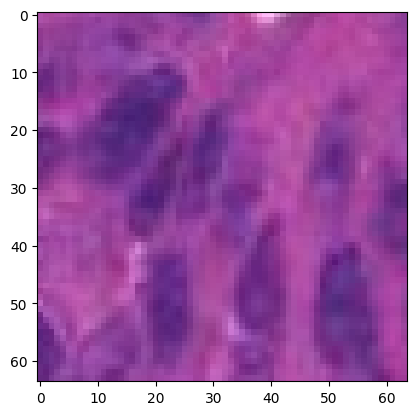

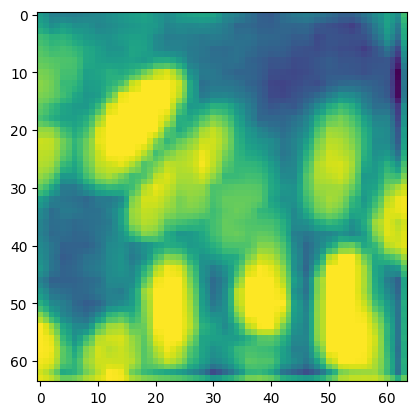

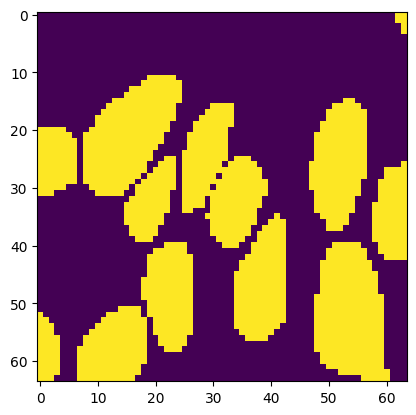

epoch 2/2, step 1020/6250, loss 0.14929692968726158, acc 0.875091552734375, time 1:48:09.860202
epoch 2/2, step 1040/6250, loss 0.14549970366060733, acc 0.8468170166015625, time 1:48:27.083692
epoch 2/2, step 1060/6250, loss 0.15194752663373948, acc 0.8803482055664062, time 1:48:44.405068
epoch 2/2, step 1080/6250, loss 0.1508910432457924, acc 0.850860595703125, time 1:49:01.604931
epoch 2/2, step 1100/6250, loss 0.14596322998404504, acc 0.830230712890625, time 1:49:18.837214
epoch 2/2, step 1120/6250, loss 0.15504849441349505, acc 0.8330612182617188, time 1:49:36.547766
epoch 2/2, step 1140/6250, loss 0.16074126735329627, acc 0.8718414306640625, time 1:49:54.158102
epoch 2/2, step 1160/6250, loss 0.1465984560549259, acc 0.8766403198242188, time 1:50:11.445919
epoch 2/2, step 1180/6250, loss 0.1494555354118347, acc 0.8589019775390625, time 1:50:28.827194
epoch 2/2, step 1200/6250, loss 0.15417549051344395, acc 0.8358993530273438, time 1:50:46.400589


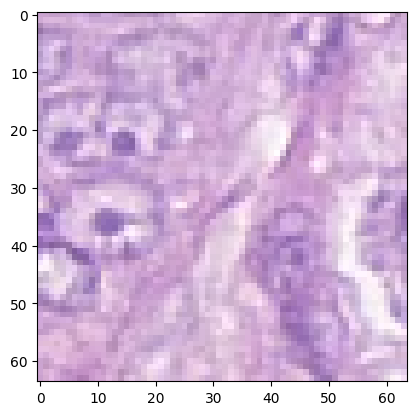

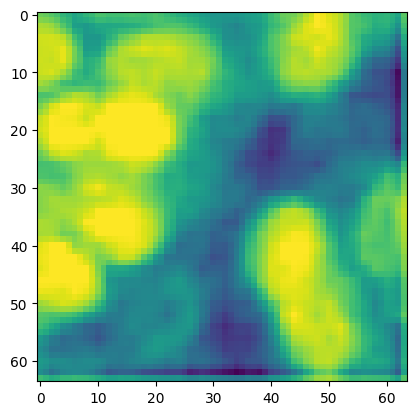

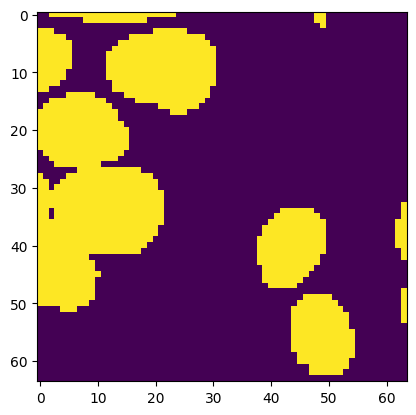

epoch 2/2, step 1220/6250, loss 0.15454502291977407, acc 0.8355712890625, time 1:51:04.241114
epoch 2/2, step 1240/6250, loss 0.1549566239118576, acc 0.859375, time 1:51:21.775871
epoch 2/2, step 1260/6250, loss 0.1544840682297945, acc 0.8673858642578125, time 1:51:39.442974
epoch 2/2, step 1280/6250, loss 0.15365445725619792, acc 0.8106155395507812, time 1:51:56.911613
epoch 2/2, step 1300/6250, loss 0.15955005213618279, acc 0.8349533081054688, time 1:52:14.774204
epoch 2/2, step 1320/6250, loss 0.14953202828764917, acc 0.8431549072265625, time 1:52:32.137145
epoch 2/2, step 1340/6250, loss 0.15727001875638963, acc 0.83685302734375, time 1:52:48.935275
epoch 2/2, step 1360/6250, loss 0.1504607655107975, acc 0.868499755859375, time 1:53:05.912693
epoch 2/2, step 1380/6250, loss 0.14766393974423409, acc 0.848907470703125, time 1:53:23.134016
epoch 2/2, step 1400/6250, loss 0.14919572770595552, acc 0.8452606201171875, time 1:53:40.510991


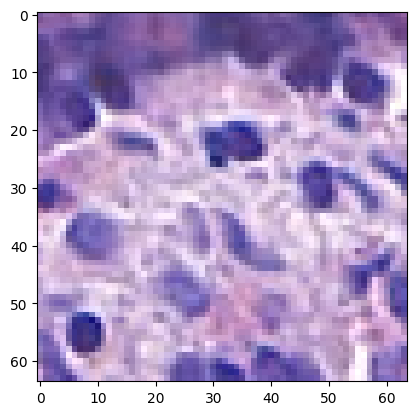

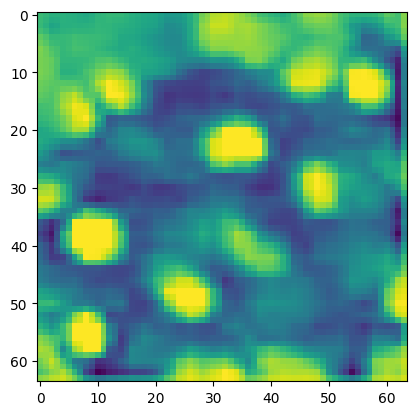

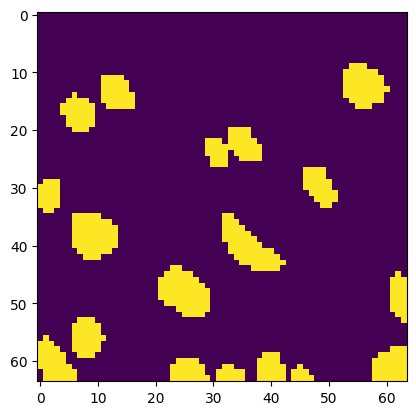

epoch 2/2, step 1420/6250, loss 0.14784592017531395, acc 0.8650283813476562, time 1:53:58.648811
epoch 2/2, step 1440/6250, loss 0.1538259744644165, acc 0.821807861328125, time 1:54:16.022105
epoch 2/2, step 1460/6250, loss 0.15111073702573777, acc 0.819580078125, time 1:54:32.998196
epoch 2/2, step 1480/6250, loss 0.14582497254014015, acc 0.878631591796875, time 1:54:50.180839
epoch 2/2, step 1500/6250, loss 0.14697637110948564, acc 0.8491439819335938, time 1:55:07.429923
epoch 2/2, step 1520/6250, loss 0.15133125931024552, acc 0.8466339111328125, time 1:55:24.325005
epoch 2/2, step 1540/6250, loss 0.14236109517514706, acc 0.8212051391601562, time 1:55:41.790093
epoch 2/2, step 1560/6250, loss 0.15029214657843112, acc 0.8452072143554688, time 1:55:59.359368
epoch 2/2, step 1580/6250, loss 0.14886108115315438, acc 0.8721237182617188, time 1:56:17.046527
epoch 2/2, step 1600/6250, loss 0.15492595173418522, acc 0.8206405639648438, time 1:56:34.837285


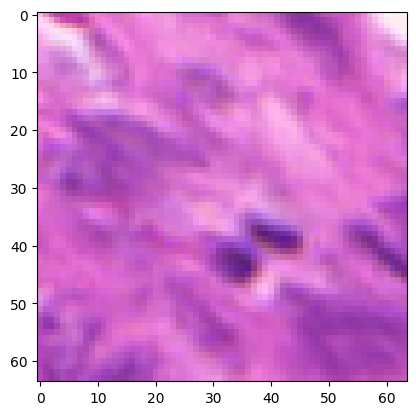

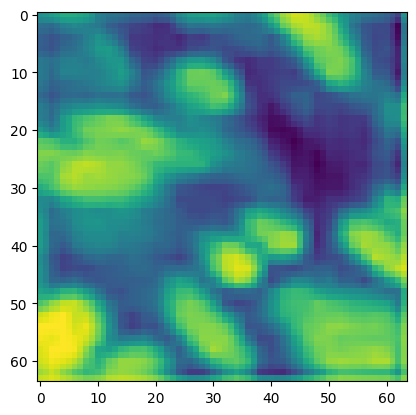

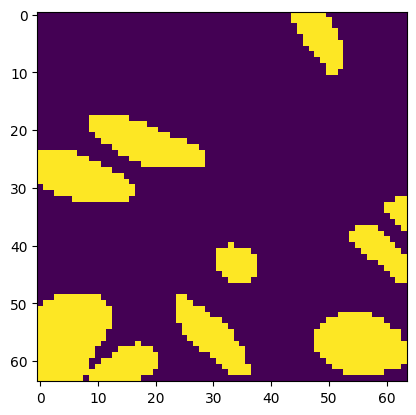

epoch 2/2, step 1620/6250, loss 0.15192365497350693, acc 0.8219375610351562, time 1:56:52.779745
epoch 2/2, step 1640/6250, loss 0.15335002765059472, acc 0.8163604736328125, time 1:57:10.626963
epoch 2/2, step 1660/6250, loss 0.14990819618105888, acc 0.8073654174804688, time 1:57:28.424152
epoch 2/2, step 1680/6250, loss 0.14977617859840392, acc 0.8180999755859375, time 1:57:45.963999
epoch 2/2, step 1700/6250, loss 0.16497273296117781, acc 0.8101425170898438, time 1:58:03.404910
epoch 2/2, step 1720/6250, loss 0.14813326634466648, acc 0.82464599609375, time 1:58:20.580879
epoch 2/2, step 1740/6250, loss 0.15583270452916623, acc 0.8404388427734375, time 1:58:37.118587
epoch 2/2, step 1760/6250, loss 0.15091468915343284, acc 0.84521484375, time 1:58:56.002910
epoch 2/2, step 1780/6250, loss 0.14695705324411393, acc 0.8126220703125, time 1:59:15.655291
epoch 2/2, step 1800/6250, loss 0.14665636382997035, acc 0.8355636596679688, time 1:59:33.641800


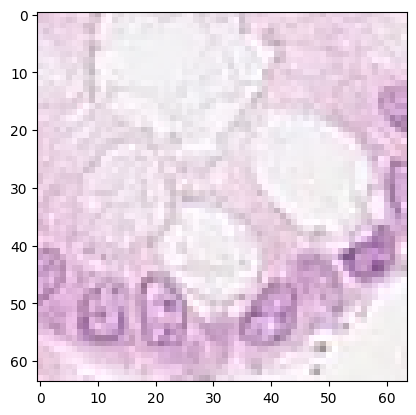

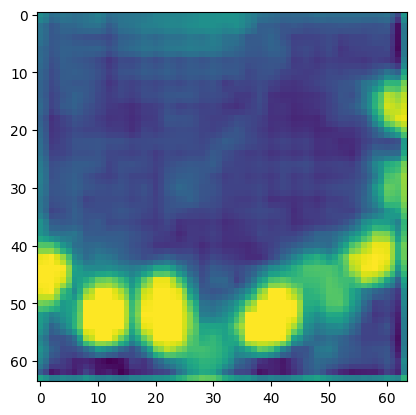

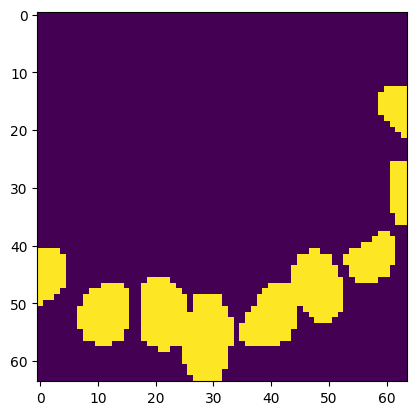

epoch 2/2, step 1820/6250, loss 0.14478264302015303, acc 0.8313522338867188, time 1:59:51.224154
epoch 2/2, step 1840/6250, loss 0.15174225047230722, acc 0.8482818603515625, time 2:00:08.600129
epoch 2/2, step 1860/6250, loss 0.1467859372496605, acc 0.8401260375976562, time 2:00:25.651351
epoch 2/2, step 1880/6250, loss 0.14129689782857896, acc 0.8549423217773438, time 2:00:42.808686
epoch 2/2, step 1900/6250, loss 0.1432168882340193, acc 0.84417724609375, time 2:01:00.089292
epoch 2/2, step 1920/6250, loss 0.15288273468613625, acc 0.813751220703125, time 2:01:17.103353
epoch 2/2, step 1940/6250, loss 0.15476062521338463, acc 0.8065948486328125, time 2:01:34.631320
epoch 2/2, step 1960/6250, loss 0.15019468888640403, acc 0.84521484375, time 2:01:51.578728
epoch 2/2, step 1980/6250, loss 0.154489815980196, acc 0.8677291870117188, time 2:02:08.871630
epoch 2/2, step 2000/6250, loss 0.1501551453024149, acc 0.8296737670898438, time 2:02:25.437785


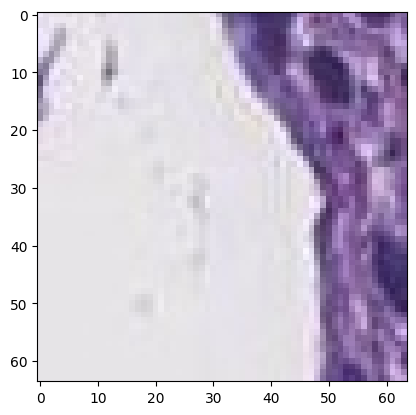

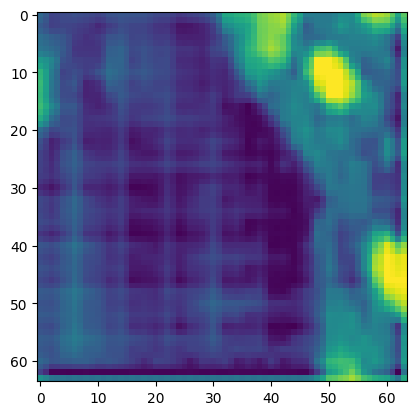

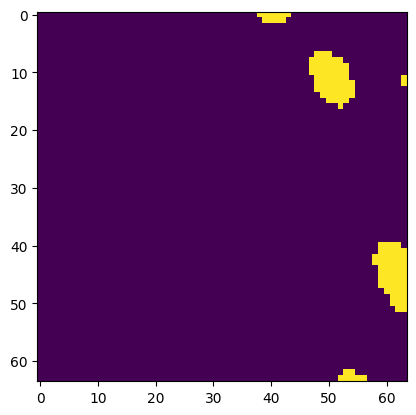

epoch 2/2, step 2020/6250, loss 0.1476910687983036, acc 0.8146514892578125, time 2:02:43.216901
epoch 2/2, step 2040/6250, loss 0.15448706559836864, acc 0.8017425537109375, time 2:03:00.450180
epoch 2/2, step 2060/6250, loss 0.14664025083184243, acc 0.8534469604492188, time 2:03:17.687926
epoch 2/2, step 2080/6250, loss 0.15136739946901798, acc 0.8552474975585938, time 2:03:35.180073
epoch 2/2, step 2100/6250, loss 0.1537223592400551, acc 0.8013687133789062, time 2:03:52.046684
epoch 2/2, step 2120/6250, loss 0.1501979187130928, acc 0.8859100341796875, time 2:04:09.368938
epoch 2/2, step 2140/6250, loss 0.15377005264163018, acc 0.8540496826171875, time 2:04:26.962445
epoch 2/2, step 2160/6250, loss 0.14774506092071532, acc 0.8160934448242188, time 2:04:44.687235
epoch 2/2, step 2180/6250, loss 0.1463279329240322, acc 0.8521957397460938, time 2:05:01.910355
epoch 2/2, step 2200/6250, loss 0.14460809752345086, acc 0.8366928100585938, time 2:05:19.499534


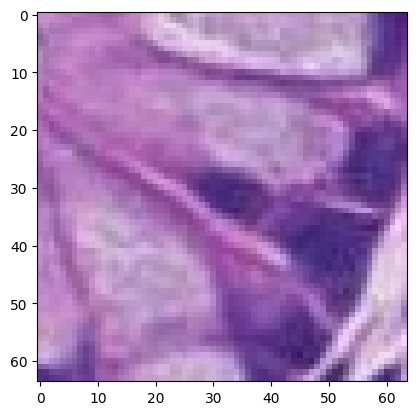

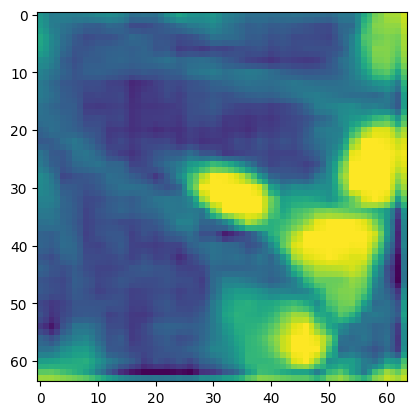

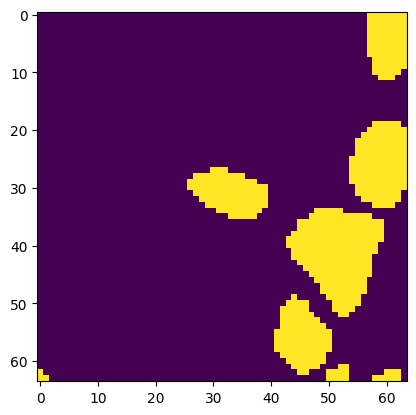

epoch 2/2, step 2220/6250, loss 0.1470596447587013, acc 0.8701400756835938, time 2:05:37.945689
epoch 2/2, step 2240/6250, loss 0.15779607370495796, acc 0.8389205932617188, time 2:05:54.848525
epoch 2/2, step 2260/6250, loss 0.14577395841479301, acc 0.8360748291015625, time 2:06:11.847014
epoch 2/2, step 2280/6250, loss 0.14474912025034428, acc 0.8211212158203125, time 2:06:29.123322
epoch 2/2, step 2300/6250, loss 0.15172795057296753, acc 0.8179092407226562, time 2:06:47.074118
epoch 2/2, step 2320/6250, loss 0.15083980187773705, acc 0.8198623657226562, time 2:07:04.337867
epoch 2/2, step 2340/6250, loss 0.1551901489496231, acc 0.8540725708007812, time 2:07:21.546667
epoch 2/2, step 2360/6250, loss 0.1474761489778757, acc 0.8580780029296875, time 2:07:39.674294
epoch 2/2, step 2380/6250, loss 0.14165102392435075, acc 0.834136962890625, time 2:07:56.992830
epoch 2/2, step 2400/6250, loss 0.14521119520068168, acc 0.8705978393554688, time 2:08:14.329113


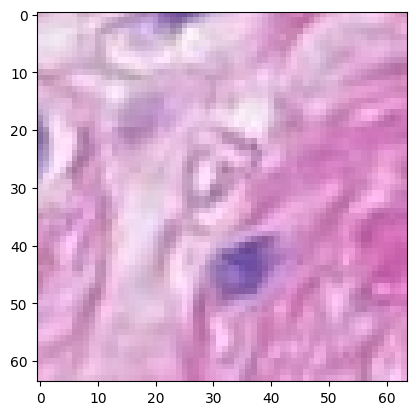

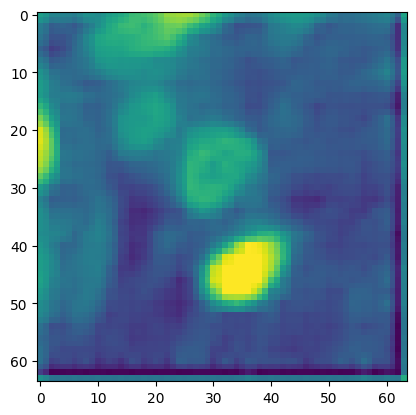

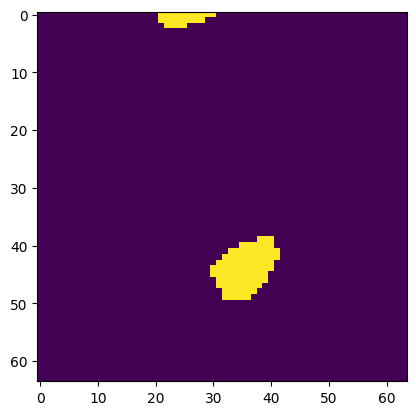

epoch 2/2, step 2420/6250, loss 0.15560757480561732, acc 0.8191909790039062, time 2:08:31.896207
epoch 2/2, step 2440/6250, loss 0.14650242626667023, acc 0.8199691772460938, time 2:08:49.515232
epoch 2/2, step 2460/6250, loss 0.16086688190698623, acc 0.8605194091796875, time 2:09:06.534187
epoch 2/2, step 2480/6250, loss 0.14120203517377378, acc 0.83477783203125, time 2:09:23.676952
epoch 2/2, step 2500/6250, loss 0.14840175472199918, acc 0.859130859375, time 2:09:40.933717
epoch 2/2, step 2520/6250, loss 0.14934490397572517, acc 0.8385848999023438, time 2:09:58.004212
epoch 2/2, step 2540/6250, loss 0.144206977635622, acc 0.8079452514648438, time 2:10:15.290662
epoch 2/2, step 2560/6250, loss 0.14739348106086253, acc 0.8405609130859375, time 2:10:32.217408
epoch 2/2, step 2580/6250, loss 0.1458090454339981, acc 0.87255859375, time 2:10:49.482158
epoch 2/2, step 2600/6250, loss 0.1440322332084179, acc 0.8379440307617188, time 2:11:06.715016


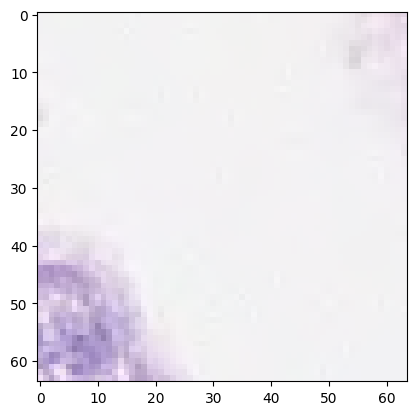

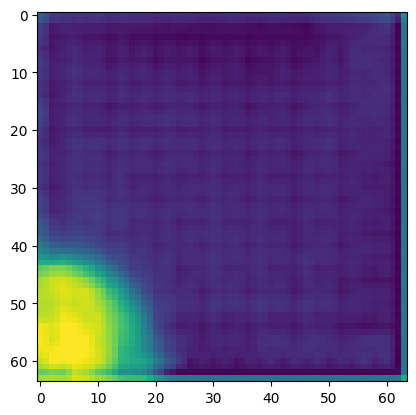

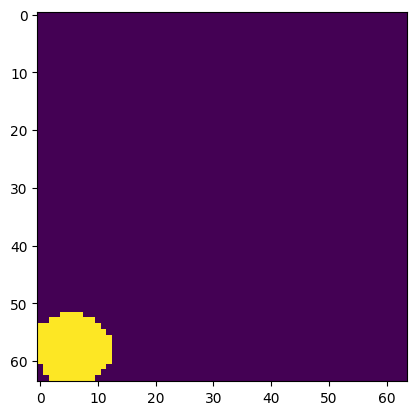

epoch 2/2, step 2620/6250, loss 0.15357690006494523, acc 0.8464584350585938, time 2:11:24.678122
epoch 2/2, step 2640/6250, loss 0.15174232199788093, acc 0.8518524169921875, time 2:11:41.938660
epoch 2/2, step 2660/6250, loss 0.14422764517366887, acc 0.8485946655273438, time 2:11:58.966052
epoch 2/2, step 2680/6250, loss 0.14940950870513917, acc 0.8173980712890625, time 2:12:16.353123
epoch 2/2, step 2700/6250, loss 0.1432901006191969, acc 0.8630142211914062, time 2:12:33.648194
epoch 2/2, step 2720/6250, loss 0.14629786200821399, acc 0.8277664184570312, time 2:12:50.662355
epoch 2/2, step 2740/6250, loss 0.14676343649625778, acc 0.8338699340820312, time 2:13:08.140556
epoch 2/2, step 2760/6250, loss 0.1581284698098898, acc 0.8157424926757812, time 2:13:25.447052
epoch 2/2, step 2780/6250, loss 0.14462219700217246, acc 0.8448333740234375, time 2:13:42.667354
epoch 2/2, step 2800/6250, loss 0.14598012790083886, acc 0.82659912109375, time 2:14:00.062427


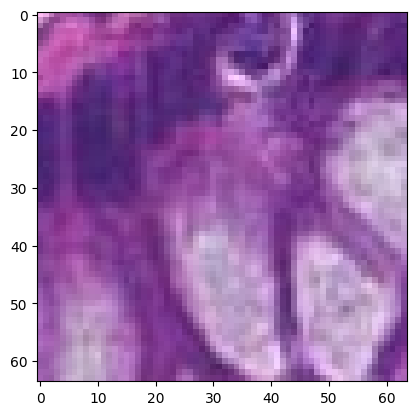

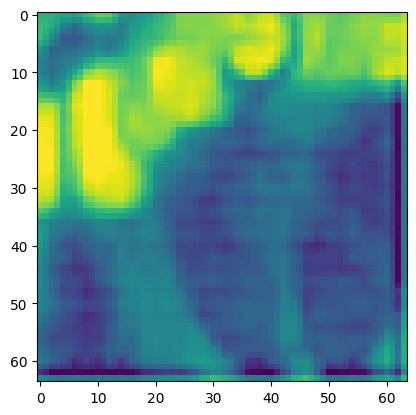

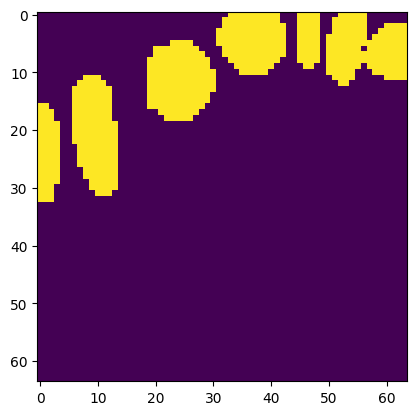

epoch 2/2, step 2820/6250, loss 0.14917649254202842, acc 0.8099746704101562, time 2:14:17.932363
epoch 2/2, step 2840/6250, loss 0.1482058919966221, acc 0.8213653564453125, time 2:14:34.897783
epoch 2/2, step 2860/6250, loss 0.14817339107394217, acc 0.8522796630859375, time 2:14:51.993820
epoch 2/2, step 2880/6250, loss 0.1437464401125908, acc 0.85223388671875, time 2:15:09.206656
epoch 2/2, step 2900/6250, loss 0.14183307848870755, acc 0.8744583129882812, time 2:15:26.589462
epoch 2/2, step 2920/6250, loss 0.1438320878893137, acc 0.8641433715820312, time 2:15:43.744071
epoch 2/2, step 2940/6250, loss 0.14913276135921477, acc 0.8549270629882812, time 2:16:00.745335
epoch 2/2, step 2960/6250, loss 0.15183999873697757, acc 0.8204727172851562, time 2:16:18.089459
epoch 2/2, step 2980/6250, loss 0.15296590849757194, acc 0.830841064453125, time 2:16:35.449790
epoch 2/2, step 3000/6250, loss 0.1501821167767048, acc 0.8265533447265625, time 2:16:52.894280


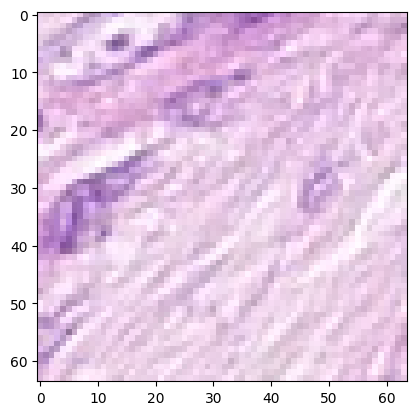

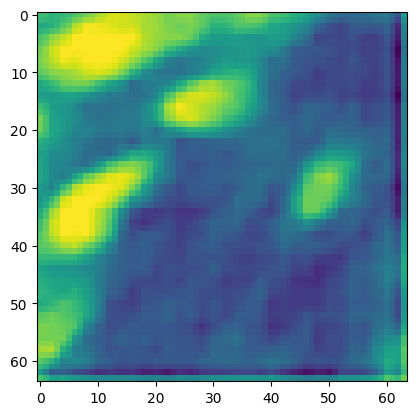

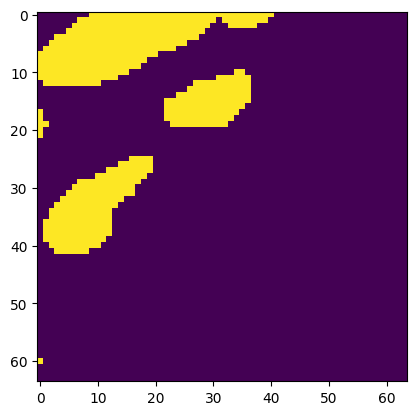

epoch 2/2, step 3020/6250, loss 0.15074133947491647, acc 0.832275390625, time 2:17:10.573793
epoch 2/2, step 3040/6250, loss 0.14784907549619675, acc 0.8155746459960938, time 2:17:28.683214
epoch 2/2, step 3060/6250, loss 0.1491964254528284, acc 0.8142242431640625, time 2:17:46.076177
epoch 2/2, step 3080/6250, loss 0.150663623213768, acc 0.8250885009765625, time 2:18:03.750949
epoch 2/2, step 3100/6250, loss 0.14751088842749596, acc 0.8327102661132812, time 2:18:21.746451
epoch 2/2, step 3120/6250, loss 0.14750083796679975, acc 0.8193283081054688, time 2:18:39.002297
epoch 2/2, step 3140/6250, loss 0.14487360678613187, acc 0.837005615234375, time 2:18:56.785595
epoch 2/2, step 3160/6250, loss 0.1499716393649578, acc 0.8380889892578125, time 2:19:14.045842
epoch 2/2, step 3180/6250, loss 0.15466184839606284, acc 0.8410263061523438, time 2:19:31.331324
epoch 2/2, step 3200/6250, loss 0.14070094078779222, acc 0.8463287353515625, time 2:19:48.626442


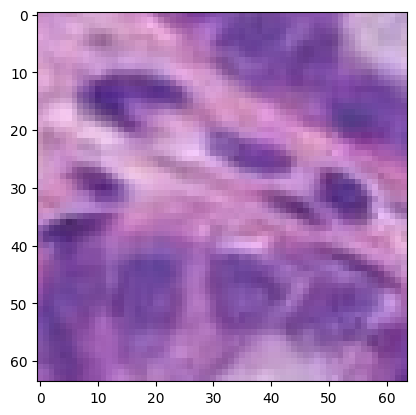

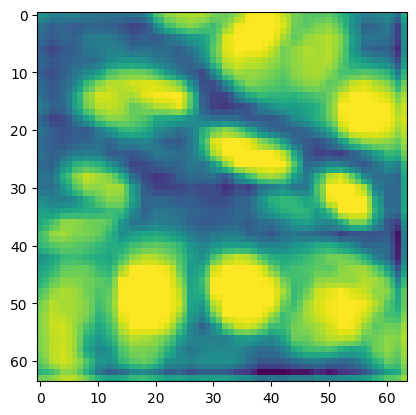

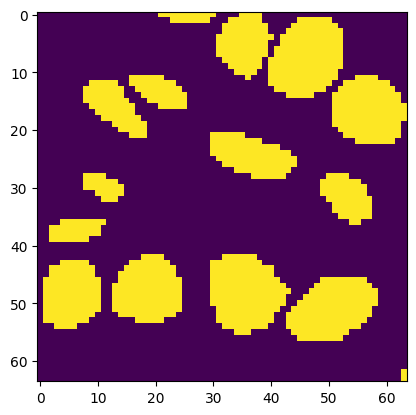

epoch 2/2, step 3220/6250, loss 0.1422678254544735, acc 0.8219146728515625, time 2:20:06.849056
epoch 2/2, step 3240/6250, loss 0.1500227652490139, acc 0.86224365234375, time 2:20:24.048349
epoch 2/2, step 3260/6250, loss 0.14744271859526634, acc 0.8231277465820312, time 2:20:41.208067
epoch 2/2, step 3280/6250, loss 0.15276318304240705, acc 0.81866455078125, time 2:20:58.781248
epoch 2/2, step 3300/6250, loss 0.14852781854569913, acc 0.8333892822265625, time 2:21:15.545972
epoch 2/2, step 3320/6250, loss 0.1532918032258749, acc 0.8512802124023438, time 2:21:32.959636
epoch 2/2, step 3340/6250, loss 0.14725973606109619, acc 0.8561782836914062, time 2:21:50.334542
epoch 2/2, step 3360/6250, loss 0.14705294445157052, acc 0.8646087646484375, time 2:22:07.997342
epoch 2/2, step 3380/6250, loss 0.14373799189925193, acc 0.8407745361328125, time 2:22:25.339040
epoch 2/2, step 3400/6250, loss 0.14213446117937564, acc 0.7870330810546875, time 2:22:42.692967


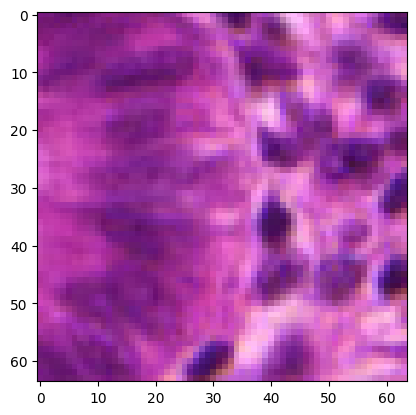

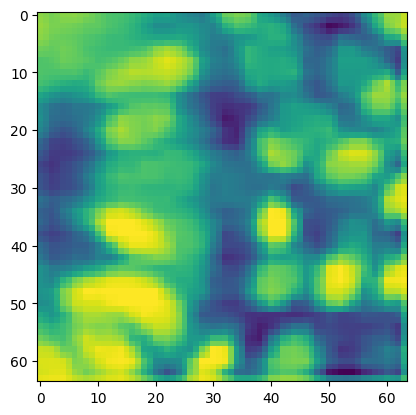

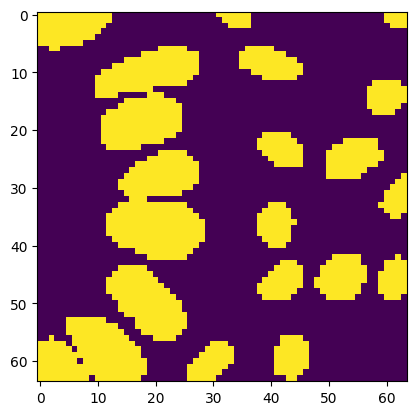

epoch 2/2, step 3420/6250, loss 0.1507804926484823, acc 0.818023681640625, time 2:23:00.580708
epoch 2/2, step 3440/6250, loss 0.15140333473682405, acc 0.7971649169921875, time 2:23:17.805347
epoch 2/2, step 3460/6250, loss 0.15243622474372387, acc 0.8397903442382812, time 2:23:34.887122
epoch 2/2, step 3480/6250, loss 0.1496409982442856, acc 0.850189208984375, time 2:23:52.174774
epoch 2/2, step 3500/6250, loss 0.15434377118945122, acc 0.8416976928710938, time 2:24:09.299789
epoch 2/2, step 3520/6250, loss 0.14694493710994722, acc 0.841766357421875, time 2:24:26.465652
epoch 2/2, step 3540/6250, loss 0.14328085966408252, acc 0.84075927734375, time 2:24:44.041211
epoch 2/2, step 3560/6250, loss 0.14323765672743322, acc 0.874420166015625, time 2:25:00.800426
epoch 2/2, step 3580/6250, loss 0.15411830469965934, acc 0.8295516967773438, time 2:25:18.218399
epoch 2/2, step 3600/6250, loss 0.15026153549551963, acc 0.799072265625, time 2:25:35.699255


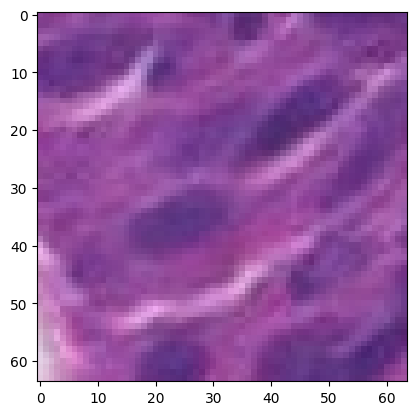

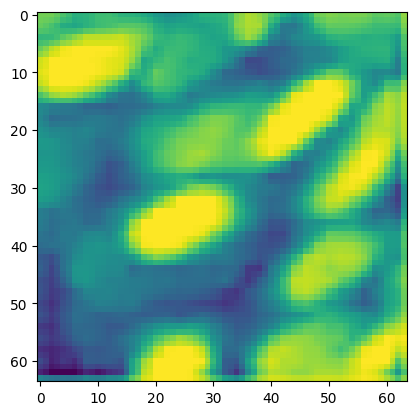

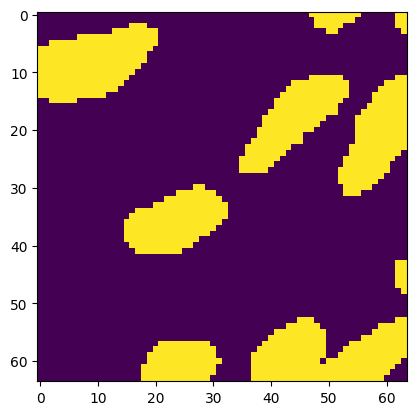

epoch 2/2, step 3620/6250, loss 0.13901992402970792, acc 0.8388442993164062, time 2:25:53.808982
epoch 2/2, step 3640/6250, loss 0.1466843742877245, acc 0.8450546264648438, time 2:26:11.044200
epoch 2/2, step 3660/6250, loss 0.14652323797345163, acc 0.8472518920898438, time 2:26:28.211175
epoch 2/2, step 3680/6250, loss 0.15158634781837463, acc 0.791778564453125, time 2:26:45.089515
epoch 2/2, step 3700/6250, loss 0.1523693311959505, acc 0.839996337890625, time 2:27:02.395609
epoch 2/2, step 3720/6250, loss 0.14673665091395377, acc 0.8455123901367188, time 2:27:19.523308
epoch 2/2, step 3740/6250, loss 0.1472437337040901, acc 0.831695556640625, time 2:27:36.955504
epoch 2/2, step 3760/6250, loss 0.14977927953004838, acc 0.7737808227539062, time 2:27:53.591741
epoch 2/2, step 3780/6250, loss 0.14672672115266322, acc 0.8675689697265625, time 2:28:10.751610
epoch 2/2, step 3800/6250, loss 0.1479700032621622, acc 0.8337936401367188, time 2:28:27.801002


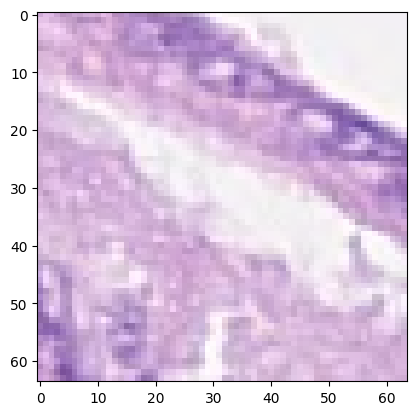

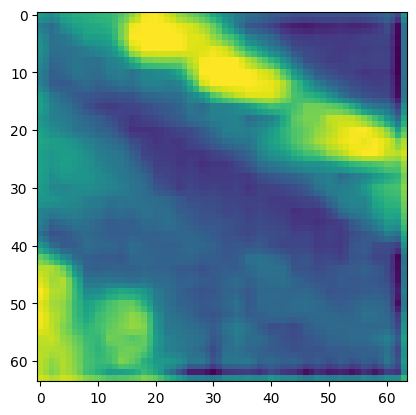

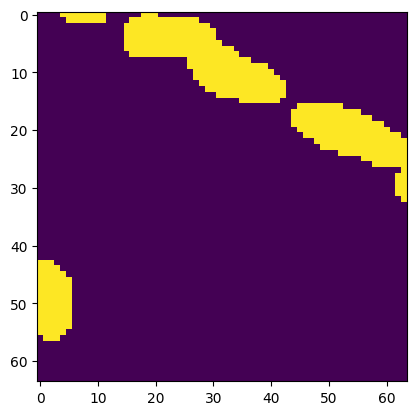

epoch 2/2, step 3820/6250, loss 0.14158633463084697, acc 0.8533935546875, time 2:28:45.361112
epoch 2/2, step 3840/6250, loss 0.1390813436359167, acc 0.8160400390625, time 2:29:02.747338
epoch 2/2, step 3860/6250, loss 0.1556762482970953, acc 0.8355484008789062, time 2:29:19.536668
epoch 2/2, step 3880/6250, loss 0.14589338824152948, acc 0.8840255737304688, time 2:29:37.355499
epoch 2/2, step 3900/6250, loss 0.14888155981898307, acc 0.8584518432617188, time 2:29:54.896031
epoch 2/2, step 3920/6250, loss 0.14263593256473542, acc 0.8602981567382812, time 2:30:11.883690
epoch 2/2, step 3940/6250, loss 0.14652471840381623, acc 0.8498611450195312, time 2:30:31.451447
epoch 2/2, step 3960/6250, loss 0.13970391303300858, acc 0.8405532836914062, time 2:30:48.748338
epoch 2/2, step 3980/6250, loss 0.14551200866699218, acc 0.8060836791992188, time 2:31:05.854798
epoch 2/2, step 4000/6250, loss 0.14794104285538195, acc 0.8547210693359375, time 2:31:23.476427


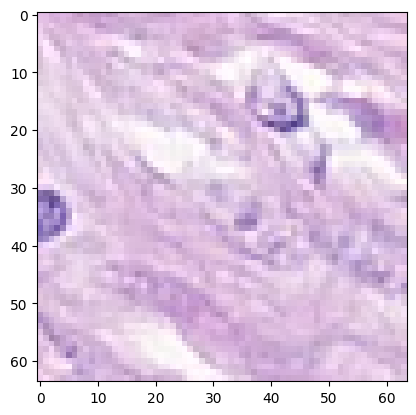

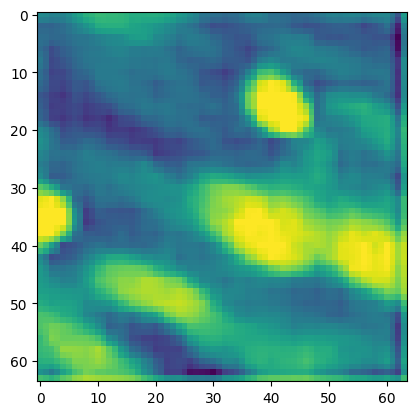

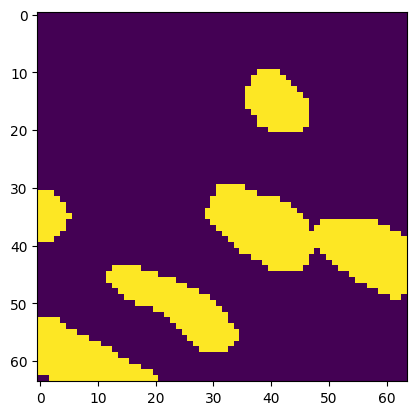

epoch 2/2, step 4020/6250, loss 0.14411057606339456, acc 0.8442153930664062, time 2:31:41.308135
epoch 2/2, step 4040/6250, loss 0.1488376010209322, acc 0.8079681396484375, time 2:31:58.518192
epoch 2/2, step 4060/6250, loss 0.1439764216542244, acc 0.8508224487304688, time 2:32:15.964964
epoch 2/2, step 4080/6250, loss 0.14799978472292424, acc 0.8445663452148438, time 2:32:33.024691
epoch 2/2, step 4100/6250, loss 0.1470908723771572, acc 0.8422698974609375, time 2:32:51.890279
epoch 2/2, step 4120/6250, loss 0.14045318439602852, acc 0.8192520141601562, time 2:33:09.375888
epoch 2/2, step 4140/6250, loss 0.1415439985692501, acc 0.824554443359375, time 2:33:27.155746
epoch 2/2, step 4160/6250, loss 0.14306300841271877, acc 0.8462371826171875, time 2:33:44.451750
epoch 2/2, step 4180/6250, loss 0.14667474590241908, acc 0.8357772827148438, time 2:34:01.920105
epoch 2/2, step 4200/6250, loss 0.14063488654792308, acc 0.825958251953125, time 2:34:19.037273


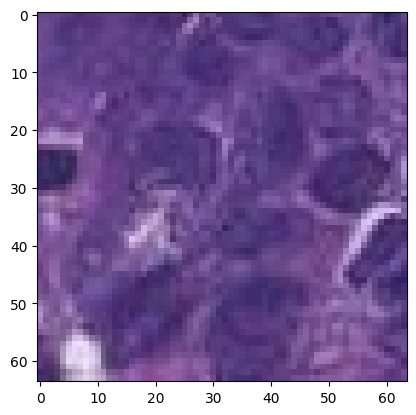

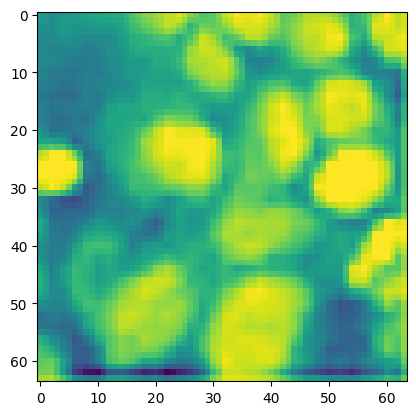

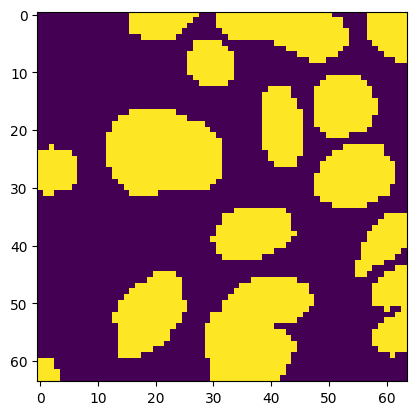

epoch 2/2, step 4220/6250, loss 0.14207472801208496, acc 0.8517379760742188, time 2:34:37.015023
epoch 2/2, step 4240/6250, loss 0.14793877601623534, acc 0.8519744873046875, time 2:34:54.132822
epoch 2/2, step 4260/6250, loss 0.13871741928160192, acc 0.87420654296875, time 2:35:11.530415
epoch 2/2, step 4280/6250, loss 0.1448613978922367, acc 0.8523330688476562, time 2:35:28.743730
epoch 2/2, step 4300/6250, loss 0.14223149195313453, acc 0.8538360595703125, time 2:35:45.823303
epoch 2/2, step 4320/6250, loss 0.13592070750892163, acc 0.844757080078125, time 2:36:02.604801
epoch 2/2, step 4340/6250, loss 0.14856966063380242, acc 0.8519668579101562, time 2:36:19.710558
epoch 2/2, step 4360/6250, loss 0.1467112645506859, acc 0.8455429077148438, time 2:36:36.908122
epoch 2/2, step 4380/6250, loss 0.15100785419344903, acc 0.82440185546875, time 2:36:54.191612
epoch 2/2, step 4400/6250, loss 0.14549808949232101, acc 0.855072021484375, time 2:37:11.460900


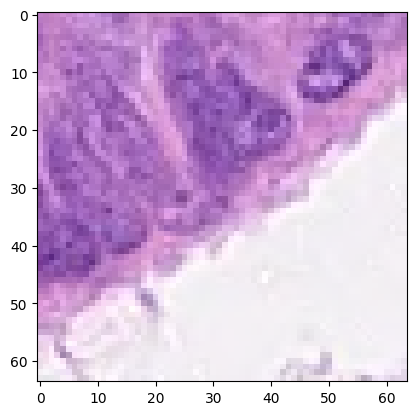

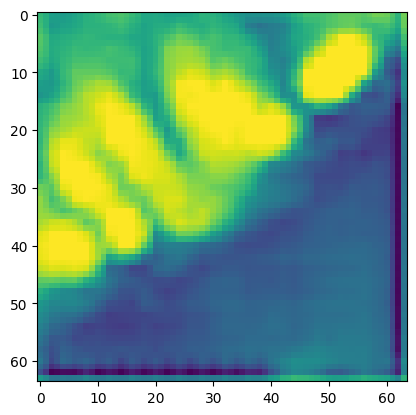

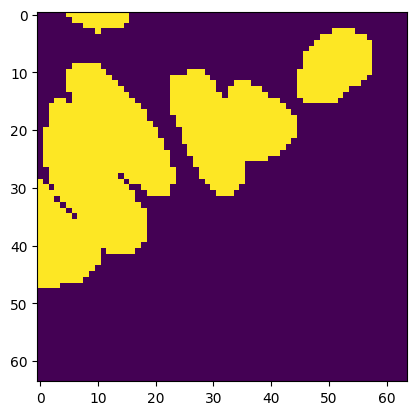

epoch 2/2, step 4420/6250, loss 0.1433389361947775, acc 0.8502273559570312, time 2:37:29.509635
epoch 2/2, step 4440/6250, loss 0.14033891931176184, acc 0.8555374145507812, time 2:37:46.957291
epoch 2/2, step 4460/6250, loss 0.15143619552254678, acc 0.8259201049804688, time 2:38:04.352408
epoch 2/2, step 4480/6250, loss 0.14494106397032738, acc 0.8710708618164062, time 2:38:21.671956
epoch 2/2, step 4500/6250, loss 0.14662812650203705, acc 0.8431472778320312, time 2:38:38.562694
epoch 2/2, step 4520/6250, loss 0.14787528067827224, acc 0.8545913696289062, time 2:38:55.709037
epoch 2/2, step 4540/6250, loss 0.14851707257330418, acc 0.8251190185546875, time 2:39:12.954711
epoch 2/2, step 4560/6250, loss 0.14600112847983837, acc 0.8622817993164062, time 2:39:30.156935
epoch 2/2, step 4580/6250, loss 0.14184002690017222, acc 0.8755722045898438, time 2:39:47.557739
epoch 2/2, step 4600/6250, loss 0.15026181265711785, acc 0.8209915161132812, time 2:40:04.689326


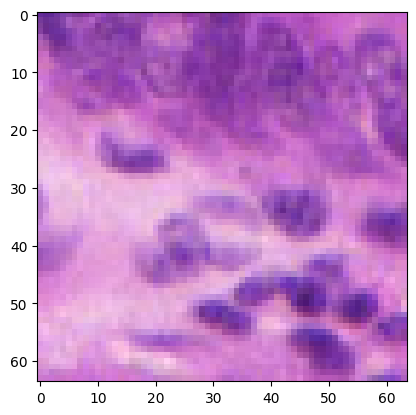

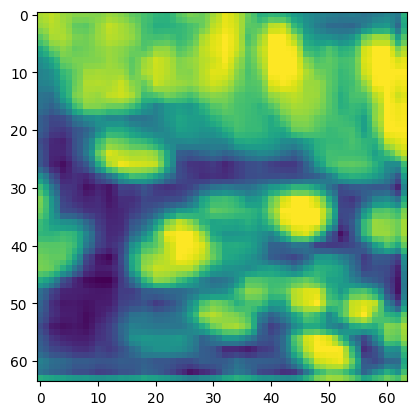

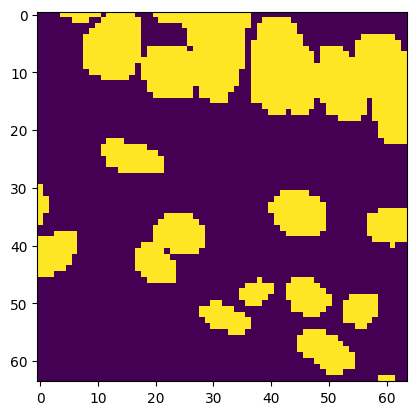

epoch 2/2, step 4620/6250, loss 0.15061475709080696, acc 0.8670806884765625, time 2:40:22.549334
epoch 2/2, step 4640/6250, loss 0.1520160213112831, acc 0.8567733764648438, time 2:40:39.710215
epoch 2/2, step 4660/6250, loss 0.1510725125670433, acc 0.8784027099609375, time 2:40:57.165040
epoch 2/2, step 4680/6250, loss 0.14796180799603462, acc 0.8395309448242188, time 2:41:14.709803
epoch 2/2, step 4700/6250, loss 0.14760808199644088, acc 0.8292083740234375, time 2:41:31.415464
epoch 2/2, step 4720/6250, loss 0.15117476023733617, acc 0.8723907470703125, time 2:41:48.705822
epoch 2/2, step 4740/6250, loss 0.14849900230765342, acc 0.8330841064453125, time 2:42:06.665639
epoch 2/2, step 4760/6250, loss 0.14205890521407127, acc 0.8301544189453125, time 2:42:25.018127
epoch 2/2, step 4780/6250, loss 0.14059198088943958, acc 0.8163299560546875, time 2:42:42.465540
epoch 2/2, step 4800/6250, loss 0.14380745887756347, acc 0.8418655395507812, time 2:42:59.491276


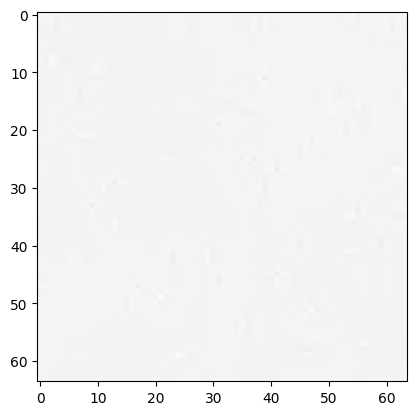

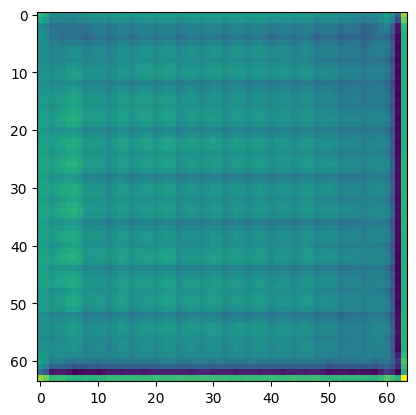

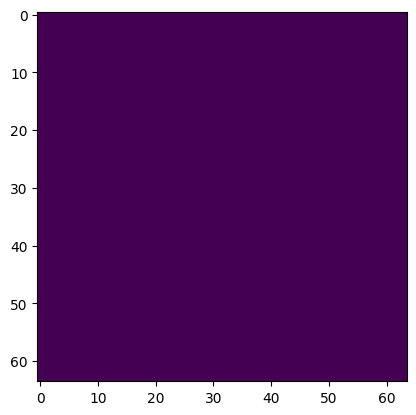

epoch 2/2, step 4820/6250, loss 0.14921022579073906, acc 0.7849807739257812, time 2:43:17.205948
epoch 2/2, step 4840/6250, loss 0.14972221218049525, acc 0.850433349609375, time 2:43:34.917271
epoch 2/2, step 4860/6250, loss 0.14444036185741424, acc 0.8419647216796875, time 2:43:52.237389
epoch 2/2, step 4880/6250, loss 0.14257266744971275, acc 0.8771820068359375, time 2:44:09.386919
epoch 2/2, step 4900/6250, loss 0.14493679963052272, acc 0.8351669311523438, time 2:44:26.522992
epoch 2/2, step 4920/6250, loss 0.1457671258598566, acc 0.8619155883789062, time 2:44:43.725072
epoch 2/2, step 4940/6250, loss 0.14638241715729236, acc 0.850006103515625, time 2:45:01.183175
epoch 2/2, step 4960/6250, loss 0.14528910778462886, acc 0.8404006958007812, time 2:45:18.213543
epoch 2/2, step 4980/6250, loss 0.14327772334218025, acc 0.8536529541015625, time 2:45:35.639839
epoch 2/2, step 5000/6250, loss 0.14306431785225868, acc 0.8356781005859375, time 2:45:53.352078


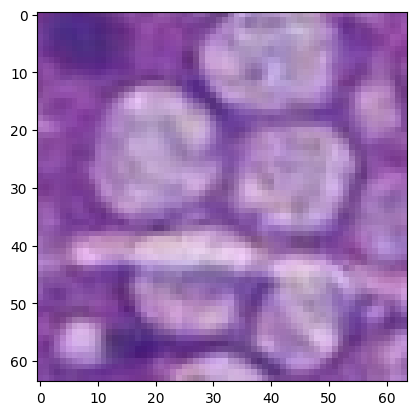

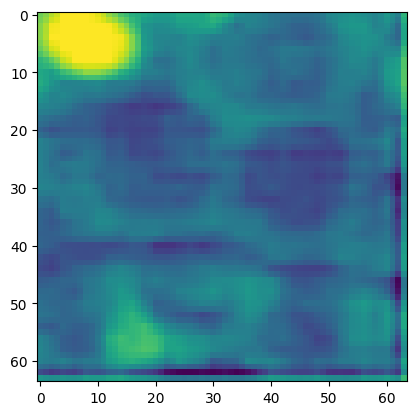

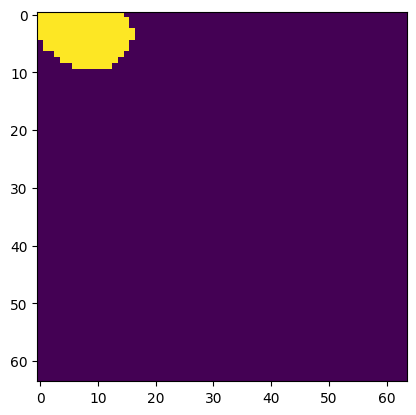

epoch 2/2, step 5020/6250, loss 0.15627421140670777, acc 0.8276901245117188, time 2:46:10.850753
epoch 2/2, step 5040/6250, loss 0.14737774953246116, acc 0.85113525390625, time 2:46:27.892478
epoch 2/2, step 5060/6250, loss 0.14943378046154976, acc 0.8414688110351562, time 2:46:45.077453
epoch 2/2, step 5080/6250, loss 0.1423392590135336, acc 0.8497390747070312, time 2:47:02.457430
epoch 2/2, step 5100/6250, loss 0.14207818768918515, acc 0.85076904296875, time 2:47:19.790047
epoch 2/2, step 5120/6250, loss 0.14649101048707963, acc 0.8551406860351562, time 2:47:36.981293
epoch 2/2, step 5140/6250, loss 0.14959217682480813, acc 0.84613037109375, time 2:47:54.309194
epoch 2/2, step 5160/6250, loss 0.15039648897945881, acc 0.8574752807617188, time 2:48:11.643006
epoch 2/2, step 5180/6250, loss 0.14234509319067, acc 0.8554916381835938, time 2:48:28.728598
epoch 2/2, step 5200/6250, loss 0.1470439899712801, acc 0.814178466796875, time 2:48:45.885172


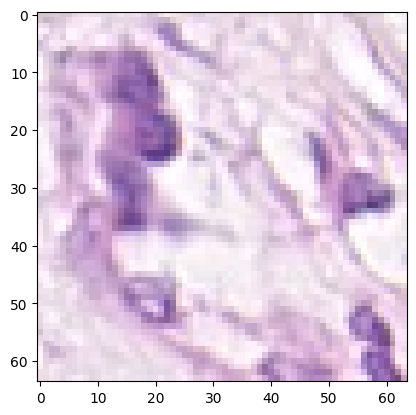

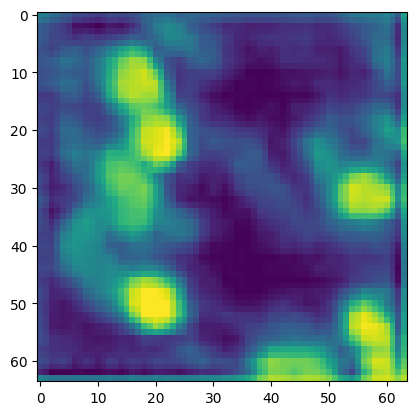

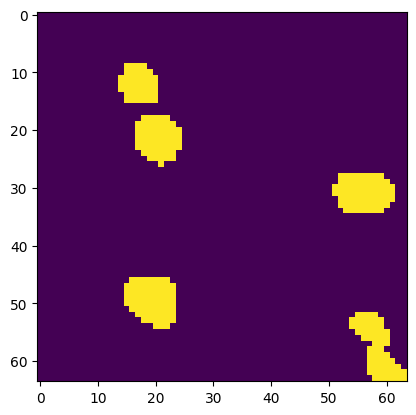

epoch 2/2, step 5220/6250, loss 0.14765485040843487, acc 0.788848876953125, time 2:49:03.480025
epoch 2/2, step 5240/6250, loss 0.1454749833792448, acc 0.8297271728515625, time 2:49:20.124198
epoch 2/2, step 5260/6250, loss 0.1486975487321615, acc 0.7887039184570312, time 2:49:37.657389
epoch 2/2, step 5280/6250, loss 0.1507125835865736, acc 0.802703857421875, time 2:49:54.570866
epoch 2/2, step 5300/6250, loss 0.1393693272024393, acc 0.8444595336914062, time 2:50:11.469922
epoch 2/2, step 5320/6250, loss 0.14847483187913896, acc 0.816925048828125, time 2:50:29.027071
epoch 2/2, step 5340/6250, loss 0.14174141958355904, acc 0.82281494140625, time 2:50:46.155354
epoch 2/2, step 5360/6250, loss 0.14972522631287574, acc 0.8204879760742188, time 2:51:03.283913
epoch 2/2, step 5380/6250, loss 0.14805616438388824, acc 0.8455047607421875, time 2:51:20.775223
epoch 2/2, step 5400/6250, loss 0.14437641613185406, acc 0.82757568359375, time 2:51:38.132778


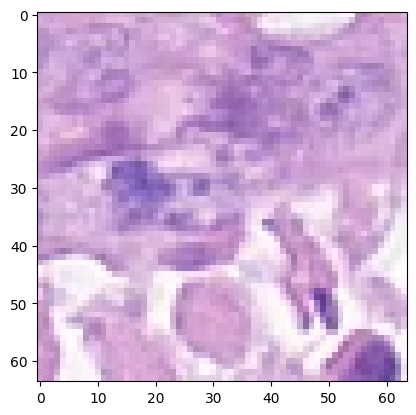

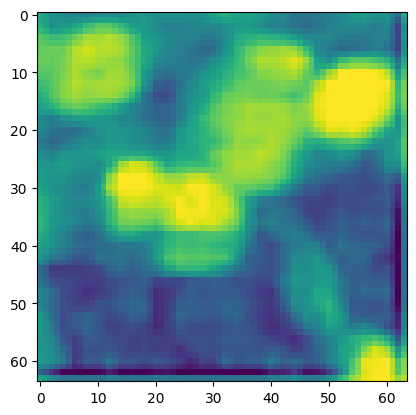

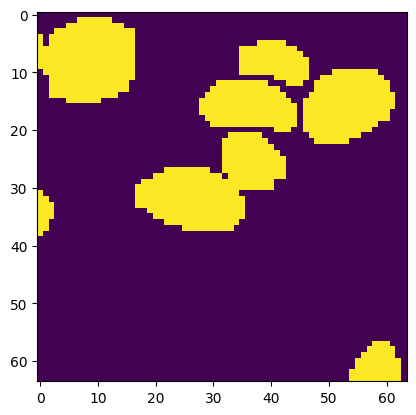

epoch 2/2, step 5420/6250, loss 0.14801175743341446, acc 0.8211746215820312, time 2:51:56.036436
epoch 2/2, step 5440/6250, loss 0.15001283213496208, acc 0.8167572021484375, time 2:52:13.383459
epoch 2/2, step 5460/6250, loss 0.1473179657012224, acc 0.8635101318359375, time 2:52:30.750725
epoch 2/2, step 5480/6250, loss 0.15156225860118866, acc 0.8253326416015625, time 2:52:47.552483
epoch 2/2, step 5500/6250, loss 0.14505873322486879, acc 0.86041259765625, time 2:53:04.886738
epoch 2/2, step 5520/6250, loss 0.14631431177258492, acc 0.8376007080078125, time 2:53:22.260406
epoch 2/2, step 5540/6250, loss 0.14721016213297844, acc 0.8363113403320312, time 2:53:39.867180
epoch 2/2, step 5560/6250, loss 0.144788608700037, acc 0.8744354248046875, time 2:53:57.130481
epoch 2/2, step 5580/6250, loss 0.1433238409459591, acc 0.85211181640625, time 2:54:14.587258
epoch 2/2, step 5600/6250, loss 0.1422840766608715, acc 0.8446807861328125, time 2:54:31.882943


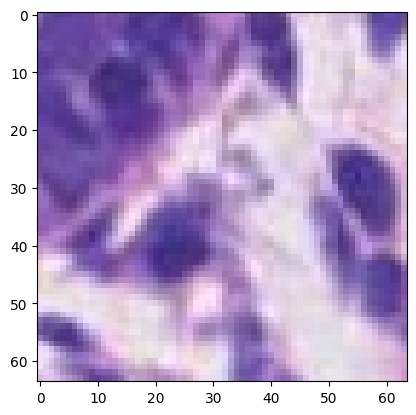

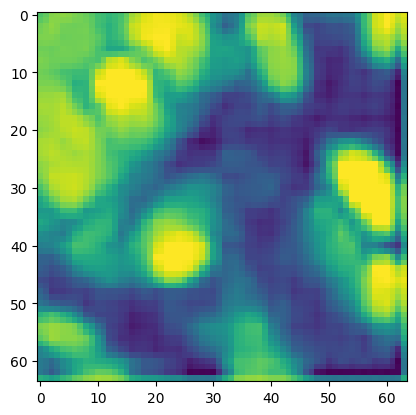

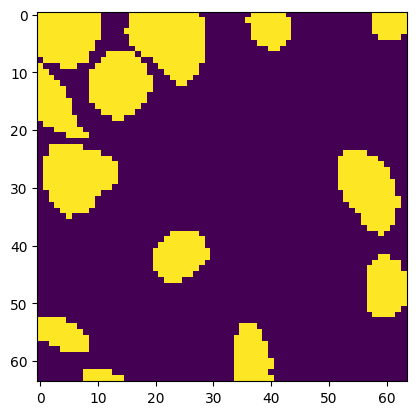

epoch 2/2, step 5620/6250, loss 0.1435972835868597, acc 0.8227767944335938, time 2:54:49.548470
epoch 2/2, step 5640/6250, loss 0.15514277145266533, acc 0.8352203369140625, time 2:55:06.618888
epoch 2/2, step 5660/6250, loss 0.1464064225554466, acc 0.8675765991210938, time 2:55:23.912420
epoch 2/2, step 5680/6250, loss 0.14252935126423835, acc 0.8305587768554688, time 2:55:41.370570
epoch 2/2, step 5700/6250, loss 0.13778636902570723, acc 0.7957077026367188, time 2:55:58.212774
epoch 2/2, step 5720/6250, loss 0.14302925877273082, acc 0.889678955078125, time 2:56:15.178410
epoch 2/2, step 5740/6250, loss 0.1467408001422882, acc 0.8415451049804688, time 2:56:32.450928
epoch 2/2, step 5760/6250, loss 0.14401508085429668, acc 0.8298416137695312, time 2:56:49.728263
epoch 2/2, step 5780/6250, loss 0.15232575461268424, acc 0.8539505004882812, time 2:57:07.039009
epoch 2/2, step 5800/6250, loss 0.14758264720439912, acc 0.8107223510742188, time 2:57:24.421529


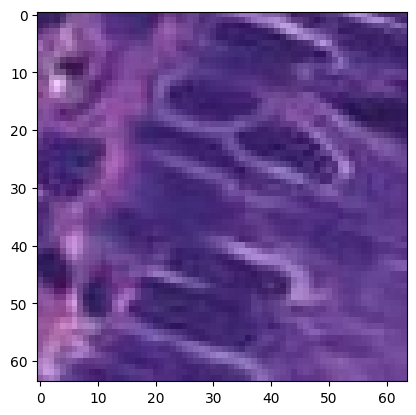

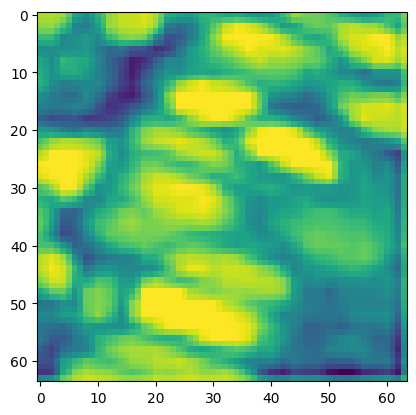

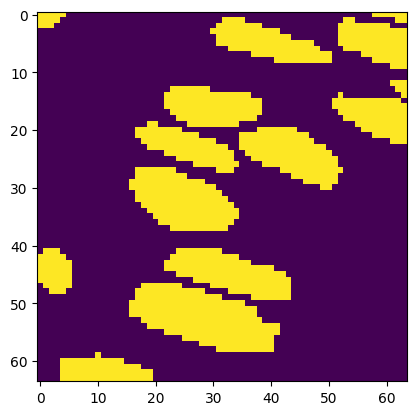

epoch 2/2, step 5820/6250, loss 0.15270494744181634, acc 0.8277206420898438, time 2:57:42.660280
epoch 2/2, step 5840/6250, loss 0.14804245457053183, acc 0.8292465209960938, time 2:57:59.617490
epoch 2/2, step 5860/6250, loss 0.14166990108788013, acc 0.80596923828125, time 2:58:16.994537
epoch 2/2, step 5880/6250, loss 0.14851948358118533, acc 0.8439788818359375, time 2:58:34.228375
epoch 2/2, step 5900/6250, loss 0.14930336475372313, acc 0.822509765625, time 2:58:52.434303
epoch 2/2, step 5920/6250, loss 0.14455280900001527, acc 0.81378173828125, time 2:59:12.700196
epoch 2/2, step 5940/6250, loss 0.1406017031520605, acc 0.8536758422851562, time 2:59:30.255150
epoch 2/2, step 5960/6250, loss 0.14450858533382416, acc 0.8355560302734375, time 2:59:47.723295
epoch 2/2, step 5980/6250, loss 0.1446158193051815, acc 0.8535385131835938, time 3:00:04.747253
epoch 2/2, step 6000/6250, loss 0.14562001936137675, acc 0.862701416015625, time 3:00:21.963465


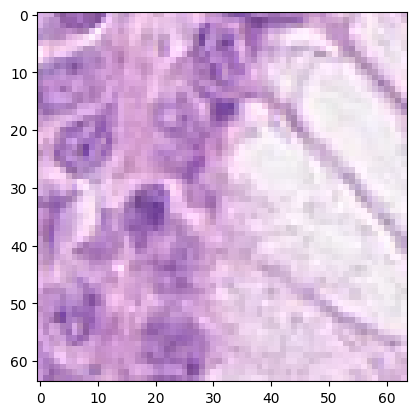

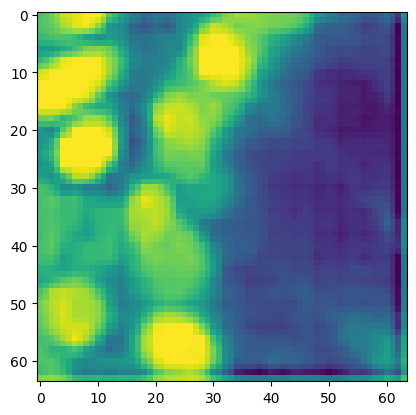

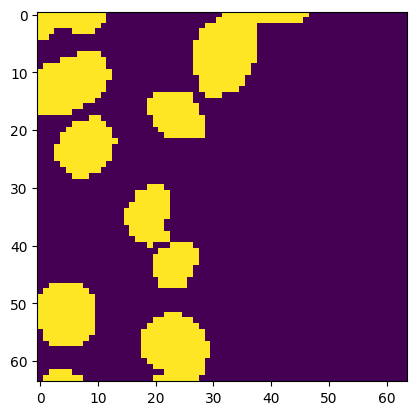

epoch 2/2, step 6020/6250, loss 0.15240485705435275, acc 0.8506622314453125, time 3:00:39.711131
epoch 2/2, step 6040/6250, loss 0.15235927514731884, acc 0.82818603515625, time 3:00:56.818412
epoch 2/2, step 6060/6250, loss 0.14328271225094796, acc 0.8577346801757812, time 3:01:14.202915
epoch 2/2, step 6080/6250, loss 0.14243033453822135, acc 0.8320541381835938, time 3:01:31.490943
epoch 2/2, step 6100/6250, loss 0.14833346828818322, acc 0.8527145385742188, time 3:01:49.251464
epoch 2/2, step 6120/6250, loss 0.1437455777078867, acc 0.8259735107421875, time 3:02:06.500859
epoch 2/2, step 6140/6250, loss 0.14494804739952089, acc 0.8158493041992188, time 3:02:23.686197
epoch 2/2, step 6160/6250, loss 0.1359282501041889, acc 0.8372421264648438, time 3:02:41.101904
epoch 2/2, step 6180/6250, loss 0.14130410589277745, acc 0.8462295532226562, time 3:02:58.497515
epoch 2/2, step 6200/6250, loss 0.13825944848358632, acc 0.8912429809570312, time 3:03:15.594037


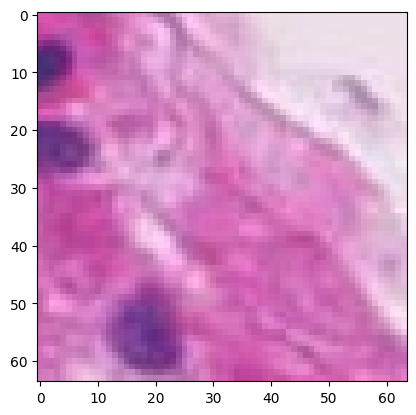

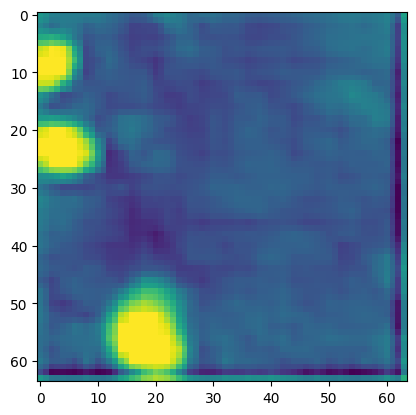

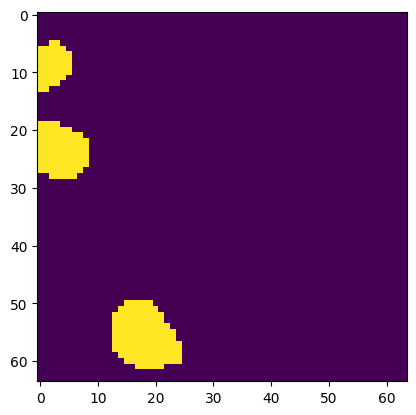

epoch 2/2, step 6220/6250, loss 0.14080341532826424, acc 0.8652191162109375, time 3:03:33.740018
epoch 2/2, step 6240/6250, loss 0.15047740787267685, acc 0.8314743041992188, time 3:03:50.826795


In [13]:
start_time = datetime.now()
for epoch in range(num_epochs):
    avg_loss = 0
    for i, (inputs, labels) in enumerate(dataloader):
        opt.zero_grad()
        outputs = net(inputs.float())
        loss = loss_fn(outputs.squeeze(1), labels.float())
        
        loss.backward()
        opt.step()
        acc = acc_metric(outputs, labels)
        wandb.log({"loss_1": loss})
        wandb.log({"acc_1": acc})
        avg_loss += loss.item()
        if (i+1) % 20 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, loss {avg_loss/20}, acc {acc}, time {(datetime.now()-start_time)}')
            avg_loss = 0
        if (i+1) % 200 == 0:
            plt.imshow(inputs[0].permute((1, 2, 0)).detach().numpy()/255)
            plt.show()
            plt.imshow(outputs[0][0].detach().numpy())
            plt.show()
            plt.imshow(labels[0].detach().numpy())
            plt.show()

Save (and load) the trained model.

In [14]:
torch.save(net, "unet_bce_adam_01_32_1")

In [19]:
net = UNET(3, 1)
net = torch.load("unet_bce_adam_001_64_1")
# net20 - BCE

Init empty arrays for calculating best threshold

In [20]:
thresholds = []
names = []
for i in np.arange(-2, 2, 0.1):
    thresholds.append([])
    names.append(np.round(i, 1))

Calculate the dice metric on testing data and calculating the best threshold.

In [21]:
dataloader_test = DataLoader(dataset=test_data, batch_size=1, shuffle=True)
total_dice = 0
total_samples = len(test_data)
n_iterations = math.ceil(total_samples/1)
with torch.no_grad():
    start_time = datetime.now()
    for i, (features, labels) in enumerate(dataloader_test):
        outputs = net(features.float())
        total_dice += dice(outputs, labels)
        for j, key in enumerate(names):
            new_outputs = torch.clone(outputs)
            new_outputs[outputs < key] = 0
            new_outputs[outputs >= key] = 1
            thresholds[j].append(dice(new_outputs, labels).item())
        if i % 1000 == 0:
            print(f'step {i} from {n_iterations} time {(datetime.now()-start_time)}')
print(f'avg dice score: {total_dice / n_iterations}')

step 0 from 44069 time 0:00:00.125787


KeyboardInterrupt: 

Threshold is calculated as best of multiple thresholds, from -2 to 2 with step 0.1

In [22]:
thresholds_copy = thresholds.copy()
for i, key in enumerate(names):
    thresholds_copy[i] = sum(thresholds[i])/len(thresholds[i])

<BarContainer object of 40 artists>

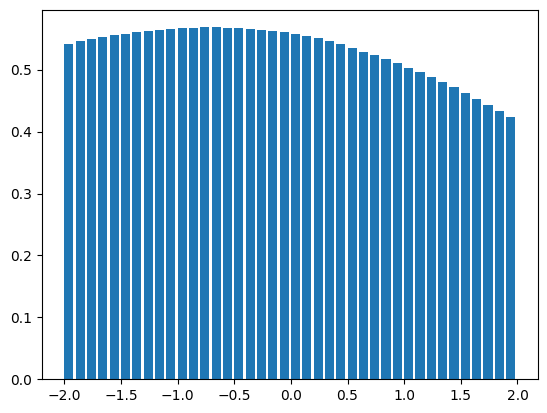

In [23]:
plt.bar(names, thresholds_copy, align='edge', width=0.08)

In [24]:
names[thresholds_copy.index(max(thresholds_copy))]

-0.7

In [16]:
net = UNET(3, 1)
net = torch.load("unet_bce_adam_01_32_1")

thresholds1 = []
names = []
for i in np.arange(-2, 2, 0.1):
    thresholds1.append([])
    names.append(np.round(i, 1))
    
dataloader_test = DataLoader(dataset=test_data, batch_size=1, shuffle=True)
total_dice = 0
total_samples = len(test_data)
n_iterations = math.ceil(total_samples/1)
with torch.no_grad():
    start_time = datetime.now()
    for i, (features, labels) in enumerate(dataloader_test):
        outputs = net(features.float())
        total_dice += dice(outputs, labels)
        for j, key in enumerate(names):
            new_outputs = torch.clone(outputs)
            new_outputs[outputs < key] = 0
            new_outputs[outputs >= key] = 1
            thresholds1[j].append(dice(new_outputs, labels).item())
        if i % 1000 == 0:
            print(f'step {i} from {n_iterations} time {(datetime.now()-start_time)}')
print(f'avg dice score: {total_dice / n_iterations}')

thresholds1_copy = thresholds1.copy()
for i, key in enumerate(names):
    thresholds1_copy[i] = sum(thresholds1[i])/len(thresholds1[i])


step 0 from 44069 time 0:00:00.058757
step 1000 from 44069 time 0:00:39.520578
step 2000 from 44069 time 0:01:19.681764
step 3000 from 44069 time 0:01:59.140108
step 4000 from 44069 time 0:02:37.969607
step 5000 from 44069 time 0:03:17.999856
step 6000 from 44069 time 0:03:56.837324
step 7000 from 44069 time 0:04:35.950796
step 8000 from 44069 time 0:05:16.401197
step 9000 from 44069 time 0:05:55.674409
step 10000 from 44069 time 0:06:34.248332
step 11000 from 44069 time 0:07:14.109691
step 12000 from 44069 time 0:07:53.042395
step 13000 from 44069 time 0:08:31.217046
step 14000 from 44069 time 0:09:10.748342
step 15000 from 44069 time 0:09:49.220001
step 16000 from 44069 time 0:10:28.794283
step 17000 from 44069 time 0:11:08.308438
step 18000 from 44069 time 0:11:47.186408
step 19000 from 44069 time 0:12:25.944339
step 20000 from 44069 time 0:13:05.687309
step 21000 from 44069 time 0:13:45.354914
step 22000 from 44069 time 0:14:23.524085
step 23000 from 44069 time 0:15:05.809520
step 

<BarContainer object of 40 artists>

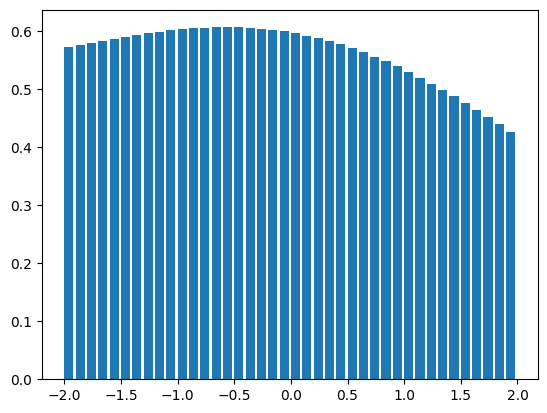

In [17]:
plt.bar(names, thresholds1_copy, align='edge', width=0.08)

In [21]:
names[thresholds1_copy.index(max(thresholds1_copy))]

-0.6

Apply the threshold to generated mask and calculate the dice metric

tensor(0.8315)


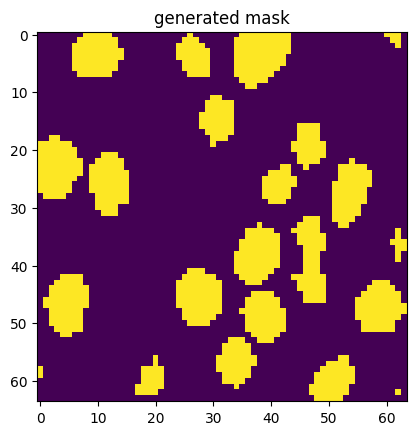

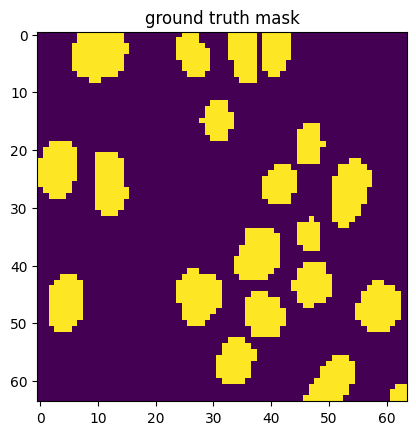

In [94]:
trashhold = 0

new_outputs = torch.clone(outputs)

new_outputs[outputs < threshold] = 0
new_outputs[outputs >= threshold] = 1
print(dice(new_outputs, labels))
plt.imshow(new_outputs[0][0].detach().numpy())
plt.title("generated mask")
plt.show()
plt.imshow(labels[0].detach().numpy())
plt.title("ground truth mask")
plt.show()

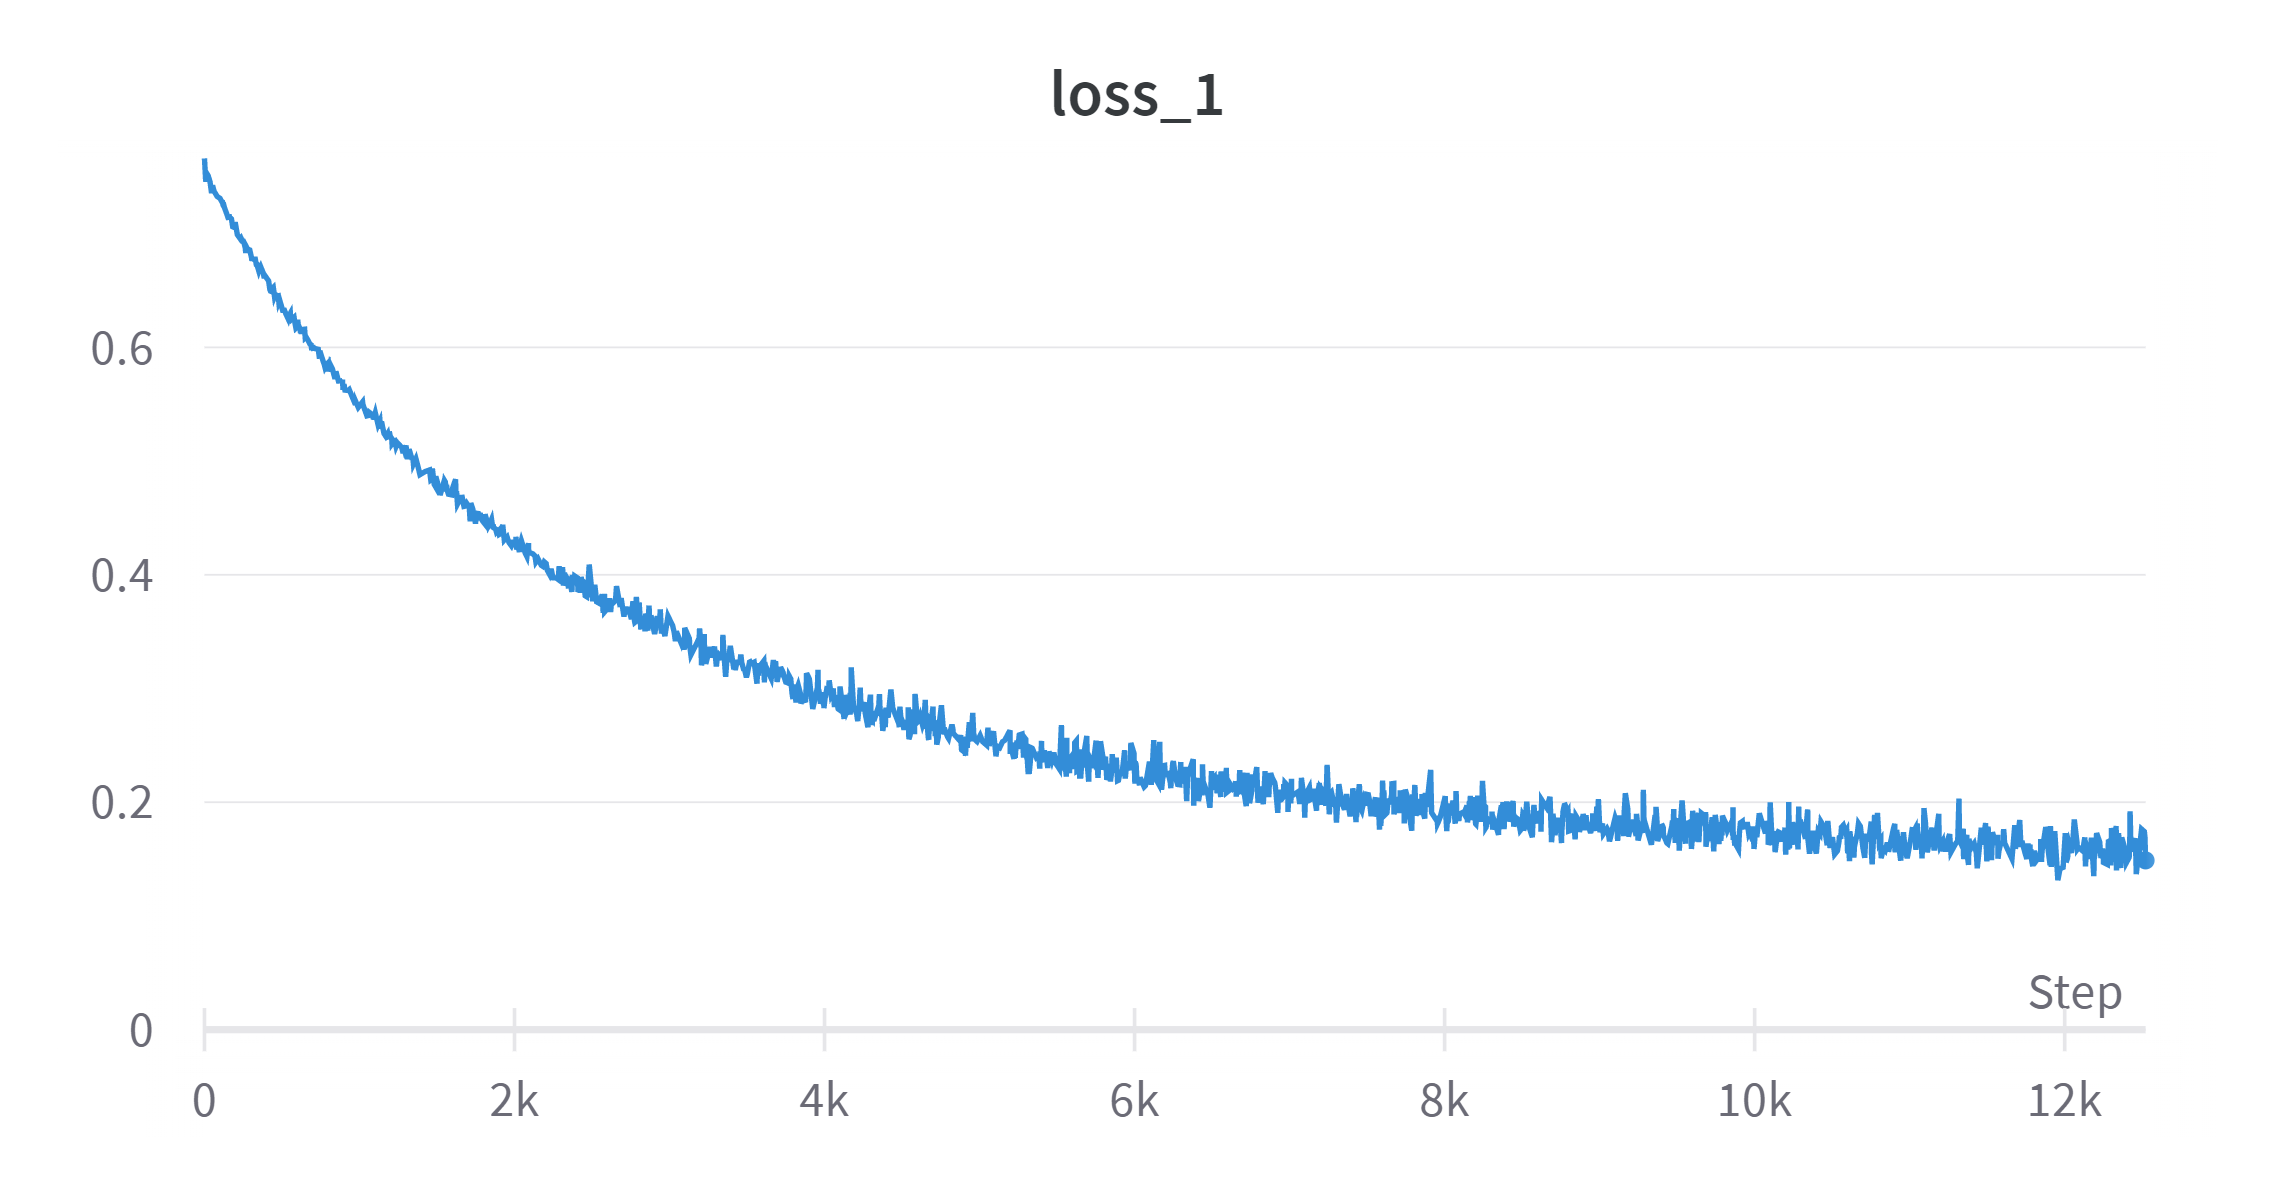

Trained for 2 epochs, final loss 0.16665339469909668 and total time 3:17:51.429321, avg dice score: 0.7841047644615173

batch 64, lr 0.001

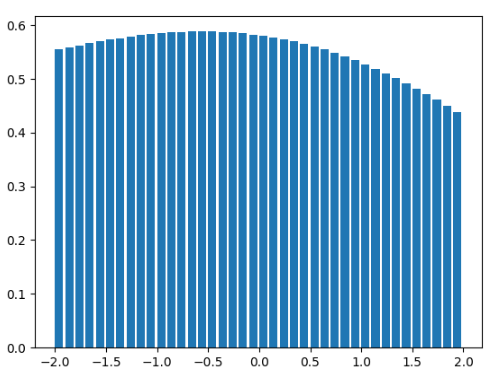

max: 0.6

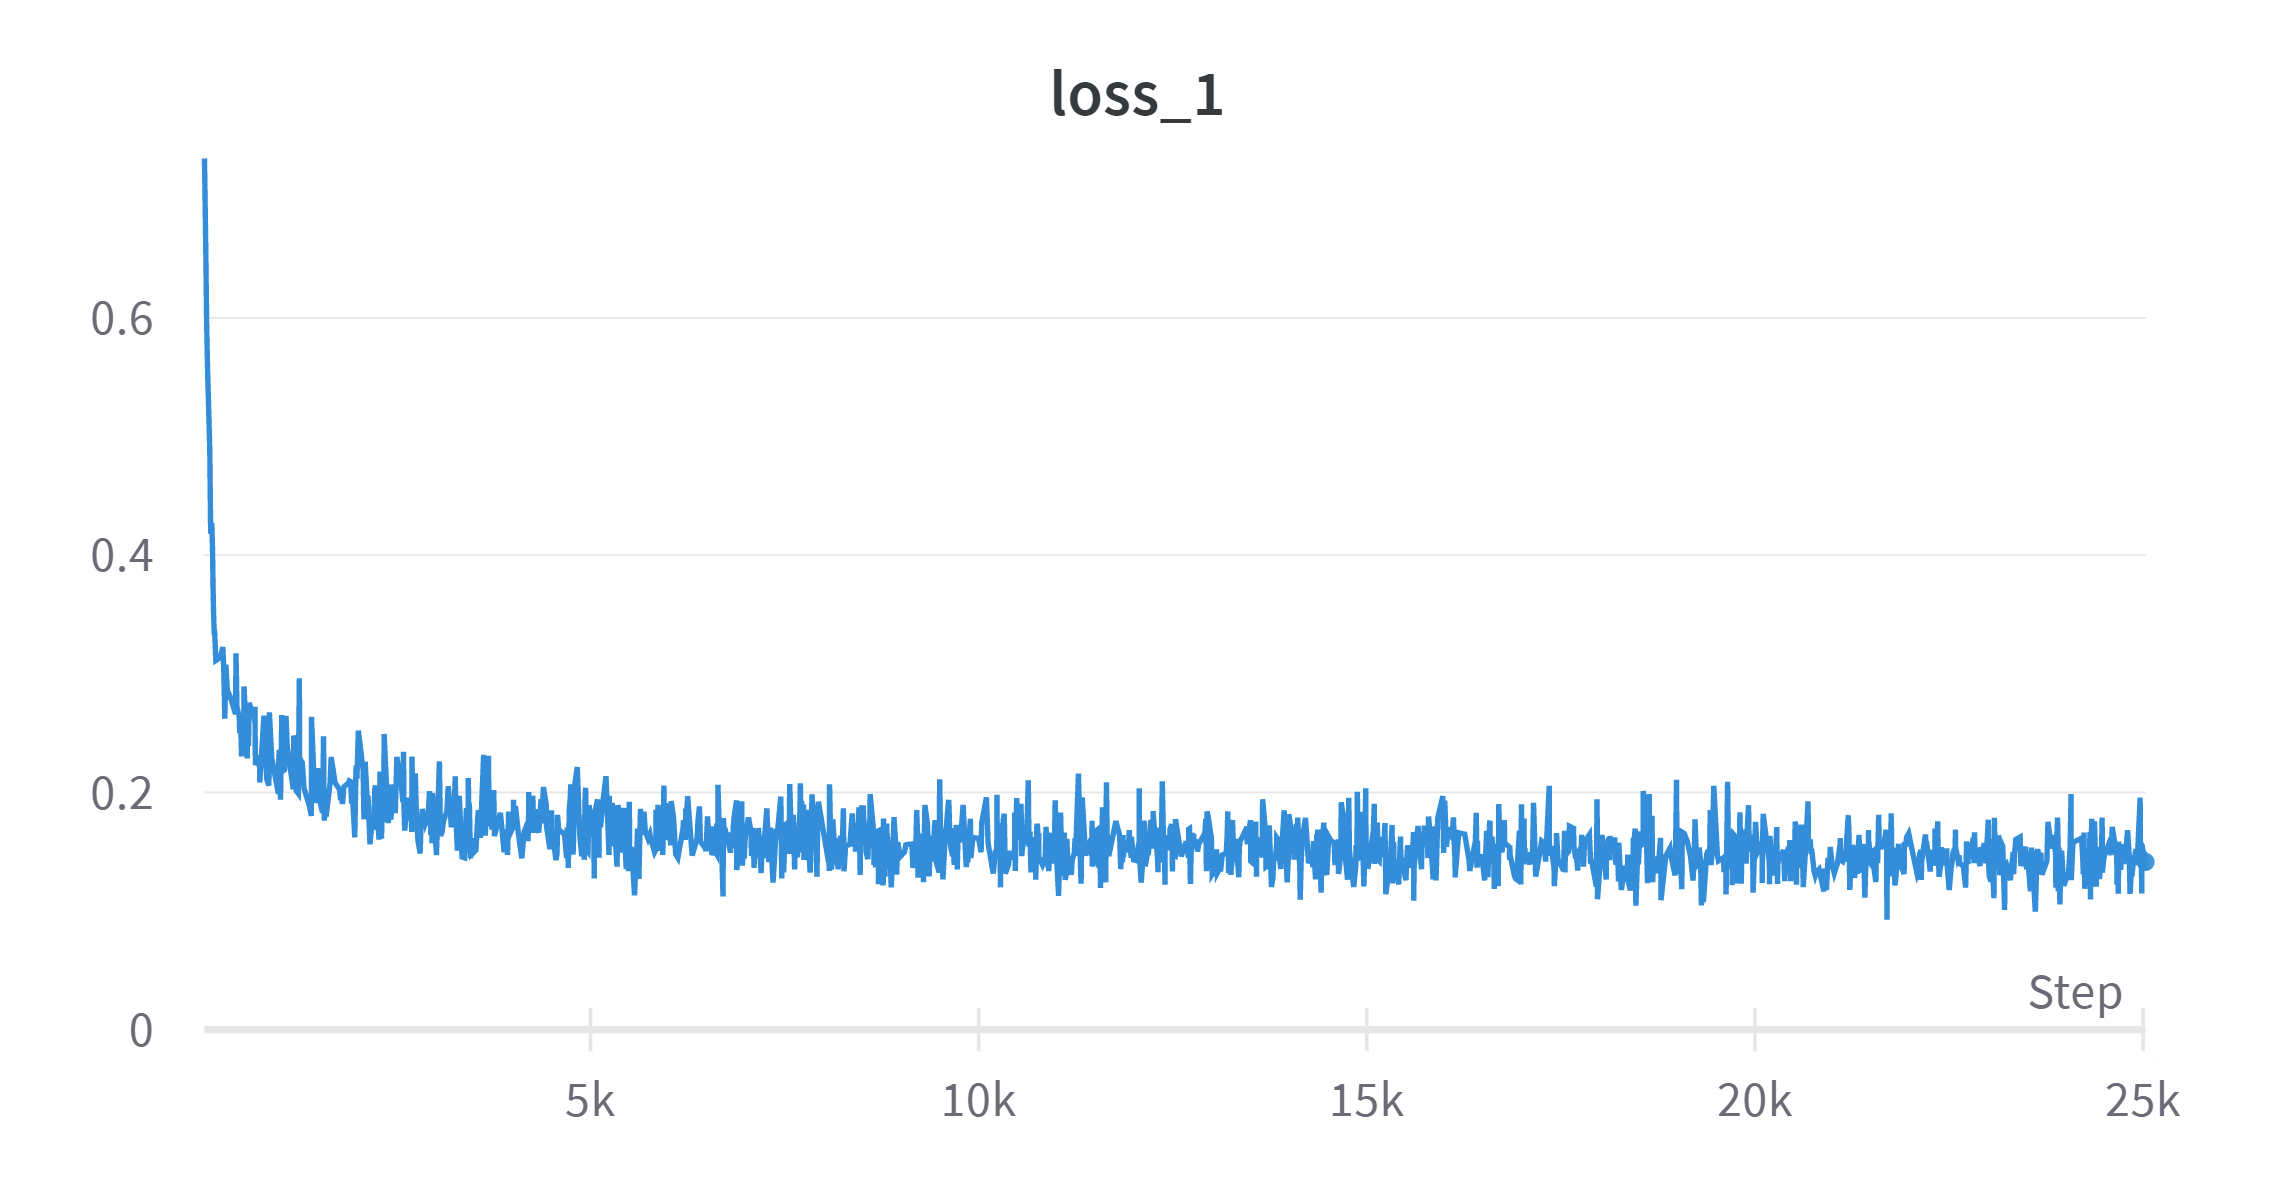

Trained for 2 epochs, final loss 0.15047740787267685 and total time 3:03:50.826795, avg dice score: 0.776847243309021

batch 32, lr 0.01

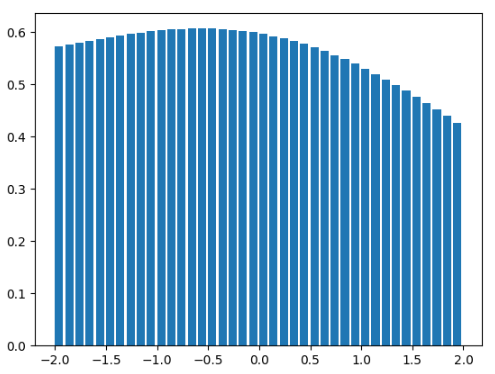

max: 0.6